# Programming Project #2: Image Quilting

## CS445: Computational Photography


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time
import random
from utils import cut

# modify to where you store your project data including utils.py
datadir = "/Users/pranav/Desktop/CS445/PROJECT2/cs445_proj2_starter_code-2"

utilfn = datadir + "utils.py"
!cp "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .
import utils

cp: /Users/pranav/Desktop/CS445/PROJECT2/cs445_proj2_starter_code-2utils.py: No such file or directory
cp: /Users/pranav/Desktop/CS445/PROJECT2/cs445_proj2_starter_code-2samples: No such file or directory


In [2]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

In [3]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    
    
    # Calculate the number of patches needed to fill the output image
    num_patches = out_size // patch_size
    
    # Create an empty output image
    out = np.zeros((out_size, out_size, 3), dtype=np.uint8)
    
    for i in range(num_patches):
        for j in range(num_patches):
            # Randomly select a patch from the sample image
            x_start = np.random.randint(0, sample.shape[0] - patch_size)
            y_start = np.random.randint(0, sample.shape[1] - patch_size)
            
            # Extract the patch from the sample
            patch = sample[x_start:x_start+patch_size, y_start:y_start+patch_size]
            
            # Place the patch in the output image
            x_dest = i * patch_size
            y_dest = j * patch_size
            out[x_dest:x_dest+patch_size, y_dest:y_dest+patch_size] = patch
    
    return out

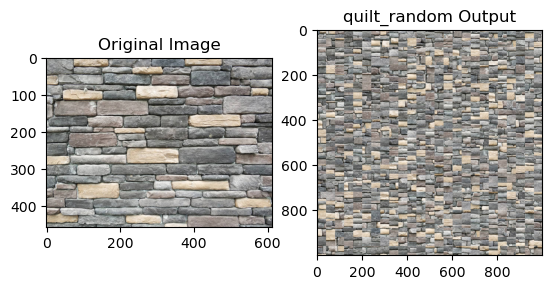

In [4]:
# Load the sample image and convert it to RGB
sample_img_fn = 'samples/quilt3.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)

# Display the original image with a label
plt.subplot(121)  # Create the first subplot
plt.imshow(sample_img)
plt.title("Original Image")  # Add a title

# Set the parameters for quilt_random
out_size = 1000  # Change these parameters as needed
patch_size = 40

# Generate and display the quilt_random image with a label
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.subplot(122)  # Create the second subplot
    plt.imshow(res)
    plt.title("quilt_random Output")  # Add a title

plt.show()  # Show both images with labels

### Part II: Overlapping Patches (30 pts)

In [5]:
def ssd_patch(T, M, I):
    T = T.astype(np.float64)
    M = M.astype(np.float64)
    I = I.astype(np.float64)
    T = T / 15
    I = I / 15

    channel1 = ((M[:, :, 0] * T[:, :, 0]) ** 2).sum() - 2 * cv2.filter2D(I[:, :, 0], ddepth=-1,
                                                                      kernel=M[:, :, 0] * T[:, :, 0]) + cv2.filter2D(
        I[:, :, 0] ** 2, ddepth=-1, kernel=M[:, :, 0])
    channel2 = ((M[:, :, 1] * T[:, :, 1]) ** 2).sum() - 2 * cv2.filter2D(I[:, :, 1], ddepth=-1,
                                                                      kernel=M[:, :, 1] * T[:, :, 1]) + cv2.filter2D(
        I[:, :, 1] ** 2, ddepth=-1, kernel=M[:, :, 1])
    channel3 = ((M[:, :, 2] * T[:, :, 2]) ** 2).sum() - 2 * cv2.filter2D(I[:, :, 2], ddepth=-1,
                                                                      kernel=M[:, :, 2] * T[:, :, 2]) + cv2.filter2D(
        I[:, :, 2] ** 2, ddepth=-1, kernel=M[:, :, 2])
    r, c = channel1.shape

    ssd = np.zeros((r, c))
    ssd[:, :] = channel1 + channel2 + channel3

    return np.absolute(ssd[:, :])

def choose_sample(cost, tol):
    minc = np.amin(cost)
    row, col = np.where(cost <= minc * (1 + tol))
    index = list(zip(list(row), list(col)))
    return random.choice(index)

def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    mask_left = np.zeros((patch_size, patch_size, 3))
    mask_left[:, :overlap, :] = 1

    mask_top = np.zeros((patch_size, patch_size, 3))
    mask_top[:overlap, :, :] = 1

    mask_other = np.zeros((patch_size, patch_size, 3))
    mask_other[:, :overlap, :] = 1
    mask_other[:overlap, :, :] = 1

    result = np.zeros((out_size, out_size, 3))
    rows = (out_size - overlap) // (patch_size - overlap)
    cols = (out_size - overlap) // (patch_size - overlap)

    for i in range(rows):
        for j in range(cols):
            if i == 0 and j == 0:
                loc_r = random.randint(0, sample.shape[0] - patch_size)
                loc_c = random.randint(0, sample.shape[1] - patch_size)
                result[:patch_size, :patch_size, :] = sample[loc_r:loc_r + patch_size, loc_c:loc_c + patch_size, :].copy()
            else:
                row_start = i * (patch_size - overlap)
                row_end = row_start + patch_size
                col_start = j * (patch_size - overlap)
                col_end = col_start + patch_size

                if i == 0:
                    ssd = ssd_patch(result[:patch_size, col_start:col_end, :], mask_left, sample)
                elif j == 0:
                    ssd = ssd_patch(result[row_start:row_end, :patch_size, :], mask_top, sample)
                else:
                    ssd = ssd_patch(result[row_start:row_end, col_start:col_end, :], mask_other, sample)

                ssd = ssd[patch_size // 2:-patch_size // 2, patch_size // 2:-patch_size // 2]
                row, col = choose_sample(ssd, tol)
                result[row_start:row_end, col_start:col_end, :] = sample[row:row + patch_size, col:col + patch_size, :].copy()

    return result

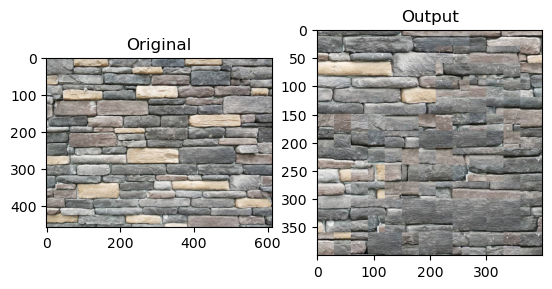

In [8]:
# Load the sample image and convert it to RGB
sample_img_fn = 'samples/quilt3.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)

# Display the original image with a label
plt.subplot(121)  # Create the first subplot
plt.imshow(sample_img)
plt.title("Original")  # Add a title

# Set the parameters for quilt_simple
out_size = 400
patch_size = 40
overlap = 10
tolerance = 1

# Generate and display the quilt_simple output image with a label
res = quilt_simple(sample_img, out_size, patch_size, overlap, tolerance)
res = res.astype(np.uint8)

if res is not None:
    plt.subplot(122)  # Create the second subplot
    plt.imshow(res)
    plt.title("Output")  # Add a title

plt.show()  # Show both images with labels

### Part III: Seam Finding (20 pts)


In [7]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost):
    pass

In [8]:
def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: int
    :return: numpy.ndarray
    """
    # Initialize the output image and mask
    output_img = np.zeros((out_size, out_size, sample.shape[2]), dtype=np.uint8)
    mask = np.zeros((out_size, out_size), dtype=bool)

    # Randomly select the first patch
    x, y = np.random.randint(0, sample.shape[0] - patch_size), np.random.randint(0, sample.shape[1] - patch_size)
    patch = sample[x:x + patch_size, y:y + patch_size, :]

    # Place the first patch in the center of the output image
    center_x, center_y = out_size // 2, out_size // 2
    output_img[center_x:center_x + patch_size, center_y:center_y + patch_size, :] = patch
    mask[center_x:center_x + patch_size, center_y:center_y + patch_size] = True

    # Calculate the boundary cost for seam finding
    bndcost = np.zeros_like(mask, dtype=float)
    bndcost[overlap:-overlap, overlap:-overlap] = np.inf

    for i in range(overlap, out_size - overlap, patch_size - overlap):
        for j in range(overlap, out_size - overlap, patch_size - overlap):
            if not mask[i, j]:
                # Calculate the boundary cost for this patch
                patch_area = output_img[i:i + patch_size, j:j + patch_size, :]
                bndcost[i:i + patch_size, j:j + patch_size] = np.sum((output_img[i:i + patch_size, j:j + patch_size, :] - patch_area) ** 2)

                # Find the seam using the cut function
                seam = cut(bndcost[i:i + patch_size, j:j + patch_size].T).T

                # Update the output image and mask with the new patch
                patch = sample[x:x + patch_size, y:y + patch_size, :]
                output_img[i:i + patch_size, j:j + patch_size, :] = patch
                mask[i:i + patch_size, j:j + patch_size] = True

                # (a) Display the two overlapping portions
                patch1 = patch_area * np.stack([seam, seam, seam], axis=-1)
                patch2 = patch * np.stack([1 - seam, 1 - seam, 1 - seam], axis=-1)

                # (b) Display pixelwise SSD cost
                ssd_cost = bndcost[i:i + patch_size, j:j + patch_size]
                plt.figure()
                plt.subplot(231)
                plt.imshow(patch1)
                plt.title("Patch 1")
                plt.subplot(232)
                plt.imshow(patch2)
                plt.title("Patch 2")
                plt.subplot(233)
                plt.imshow(ssd_cost, cmap='viridis')
                plt.title("SSD Cost")

                # (c) Display horizontal mask
                h_mask = np.zeros_like(seam)
                h_mask[:, :-1] = np.logical_and(seam[:, :-1], 1 - seam[:, 1:])
                plt.subplot(234)
                plt.imshow(h_mask, cmap='gray')
                plt.title("Horizontal Mask")

                # (d) Display vertical mask
                v_mask = np.zeros_like(seam)
                v_mask[:-1, :] = np.logical_and(seam[:-1, :], 1 - seam[1:, :])
                plt.subplot(235)
                plt.imshow(v_mask, cmap='gray')
                plt.title("Vertical Mask")
                
                # (e) Display combination mask
                comb_mask = np.logical_or(h_mask, v_mask)
                plt.subplot(236)
                plt.imshow(comb_mask, cmap='gray')
                plt.title("Combination Mask")
                

    return output_img

/var/folders/3b/w1xrz_gs2v9fyqlq407h6qg00000gn/T/ipykernel_28991/3253622177.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()
/var/folders/3b/w1xrz_gs2v9fyqlq407h6qg00000gn/T/ipykernel_28991/699884973.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122)  # Create the second subplot


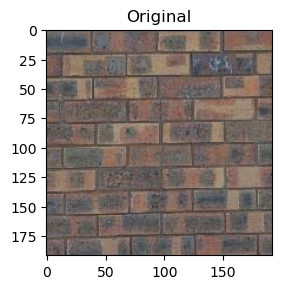

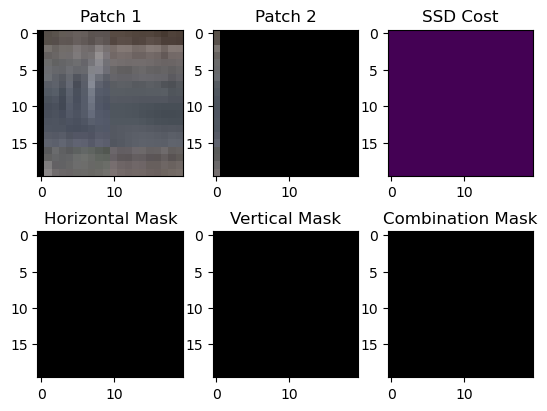

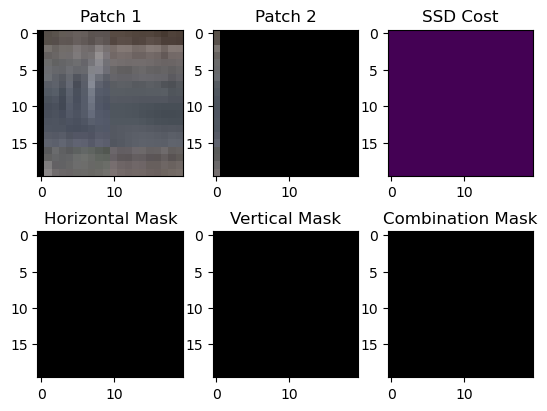

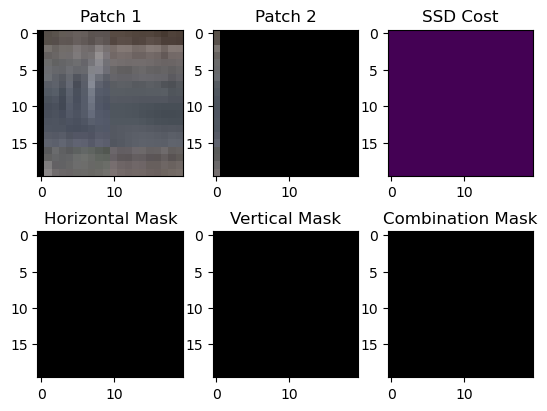

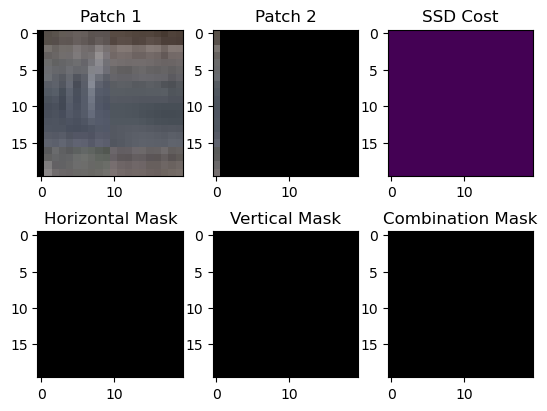

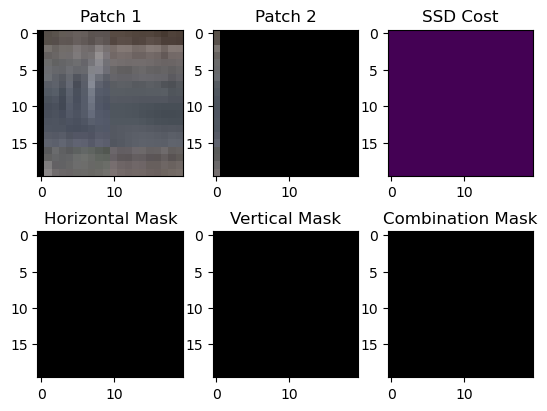

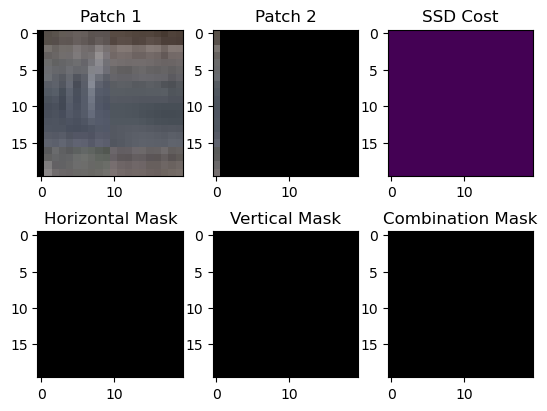

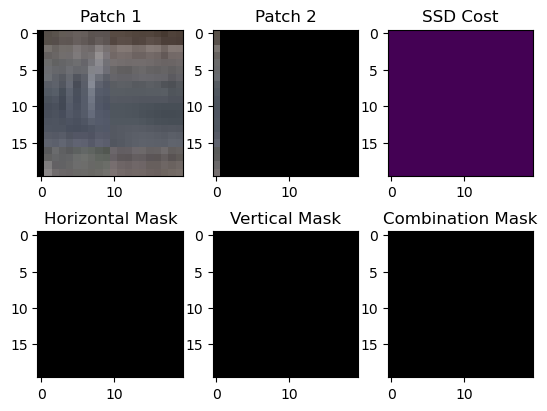

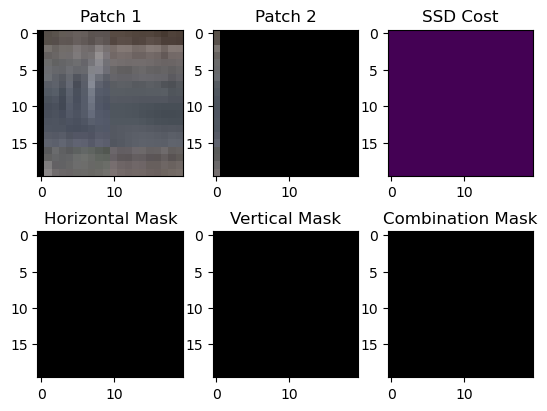

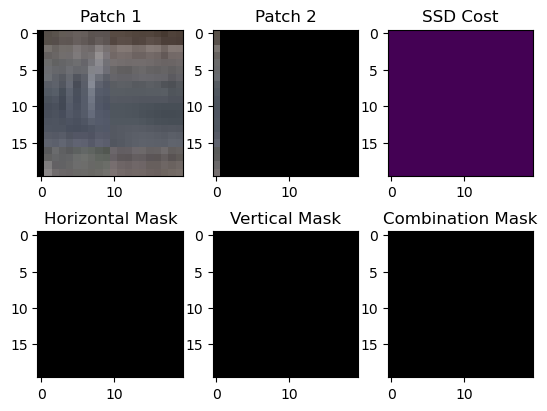

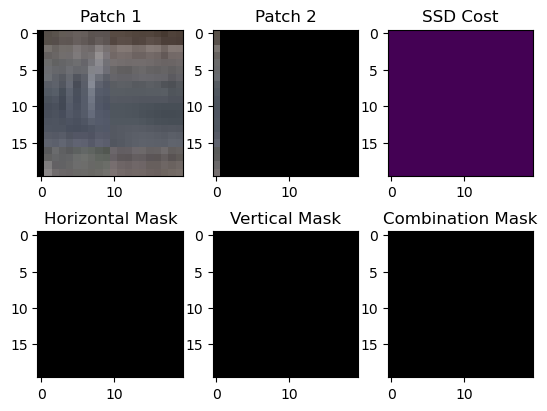

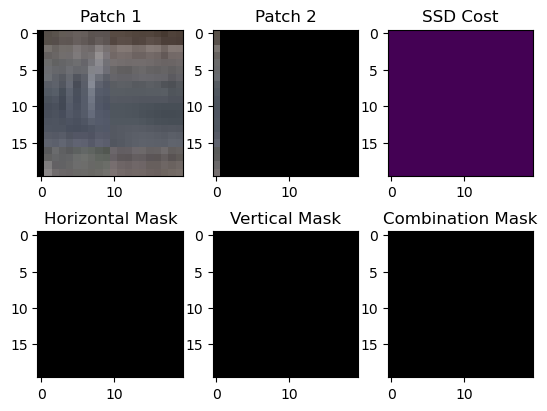

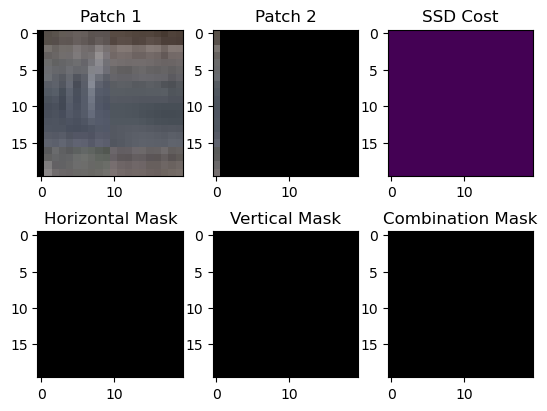

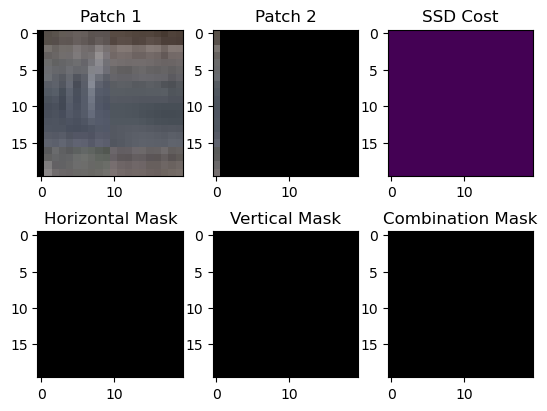

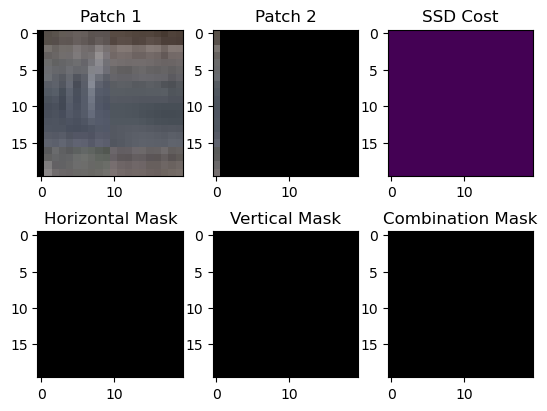

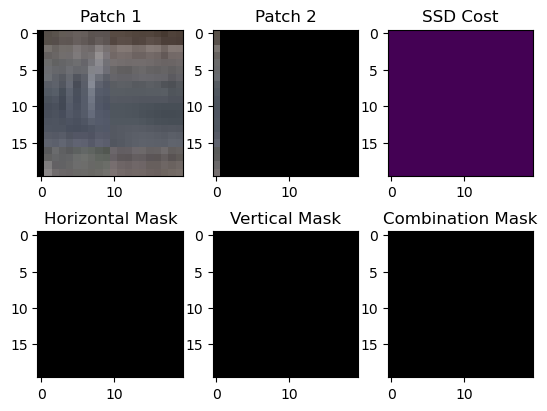

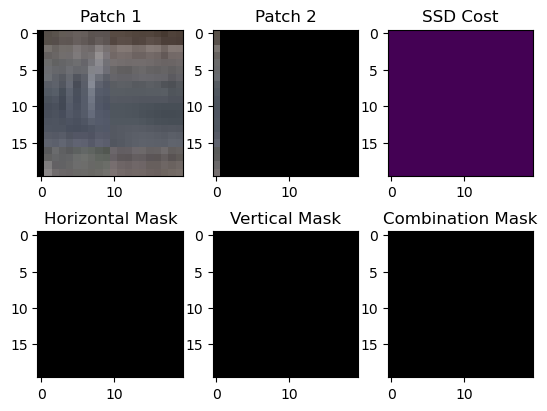

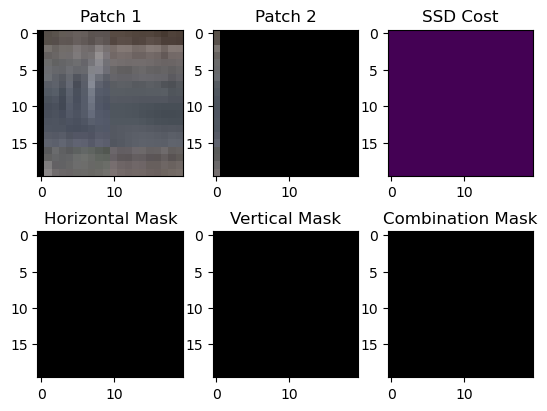

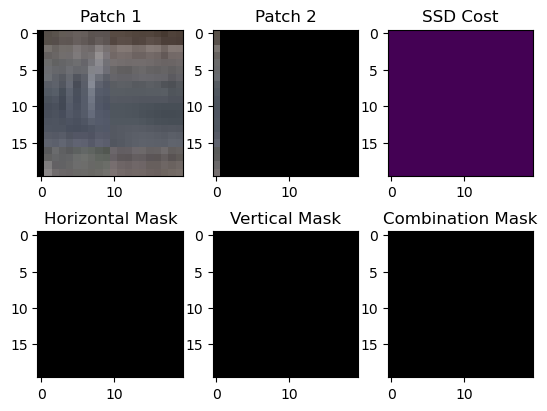

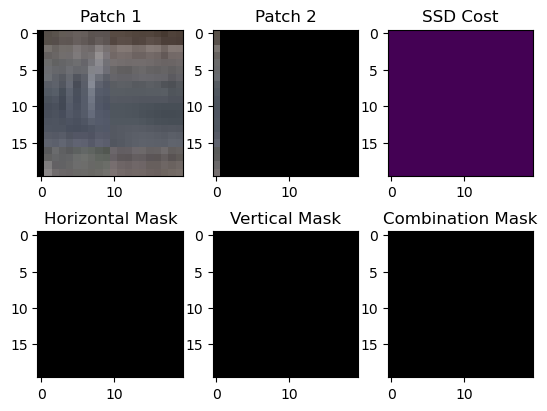

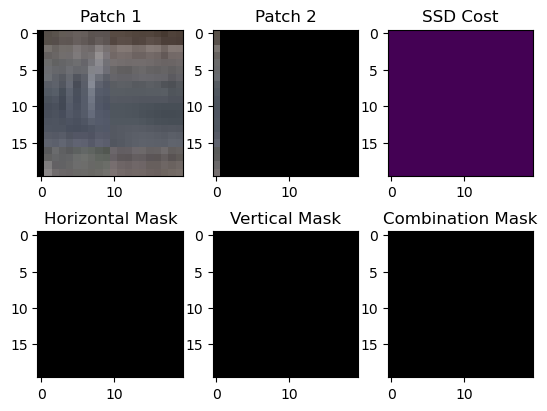

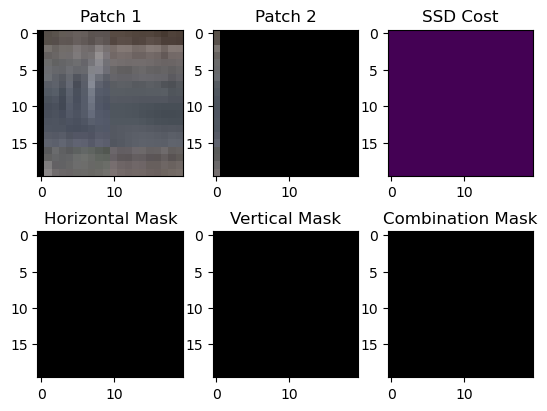

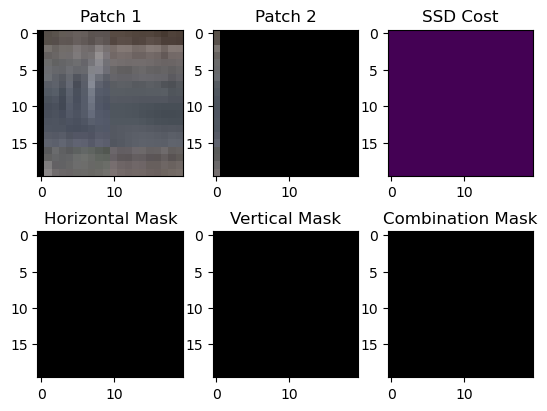

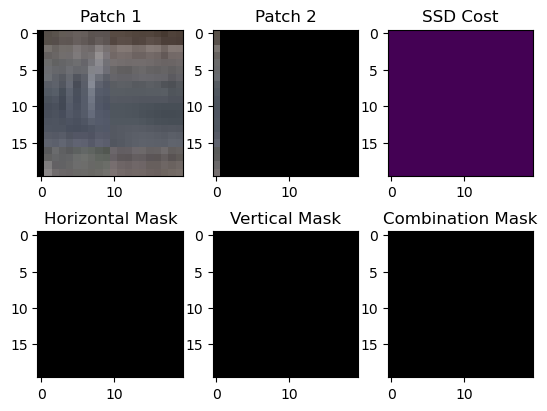

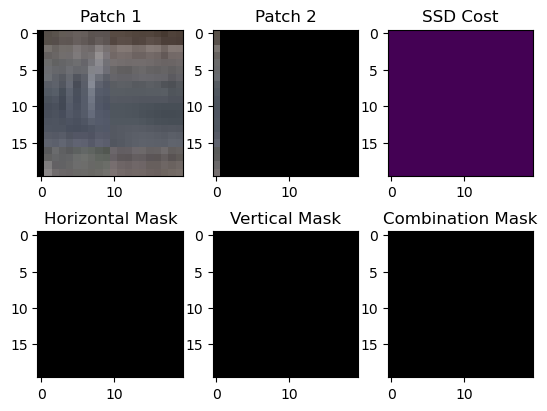

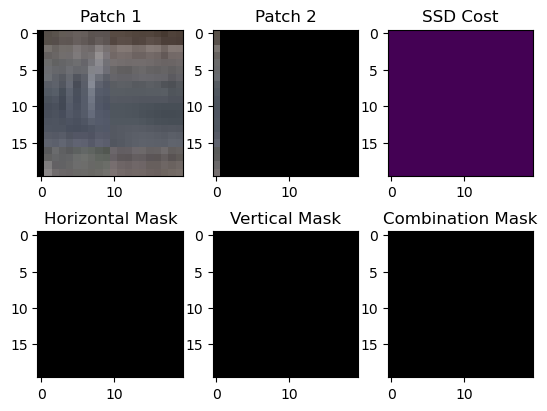

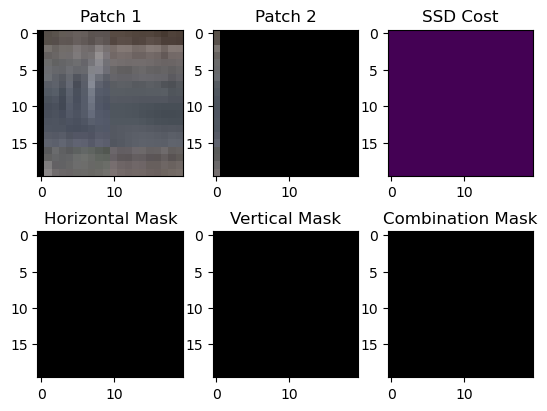

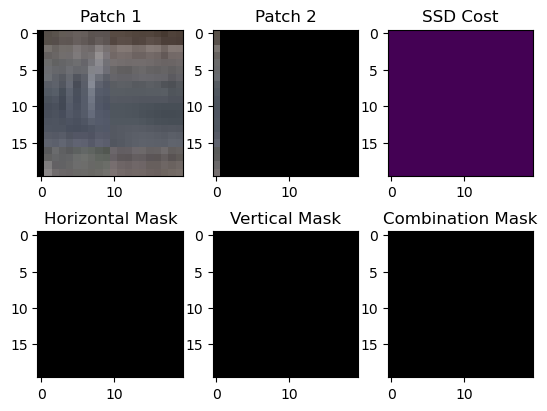

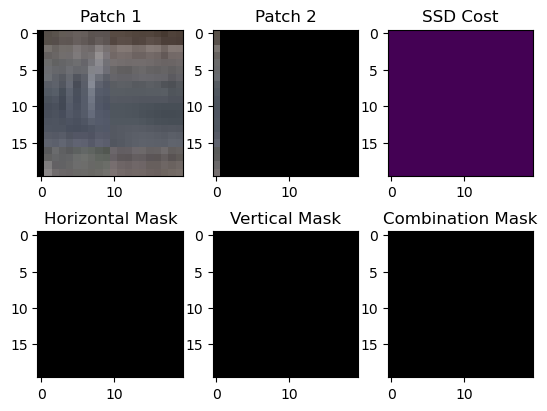

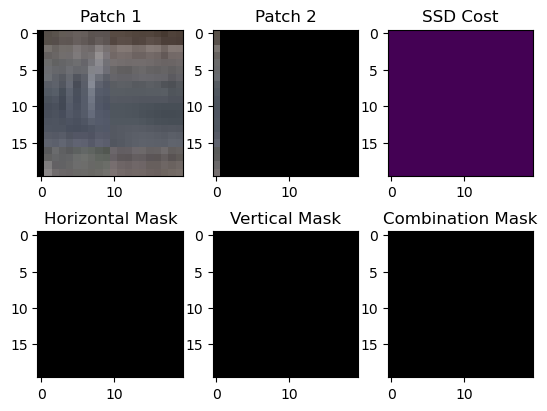

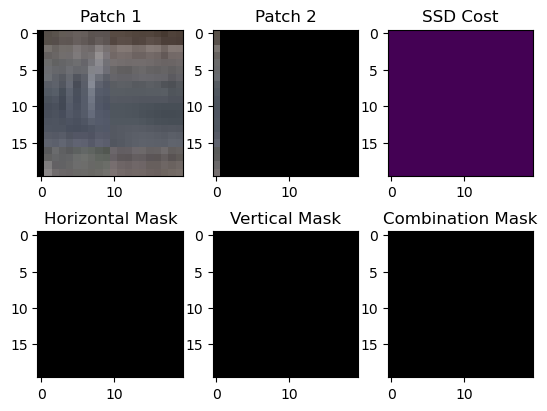

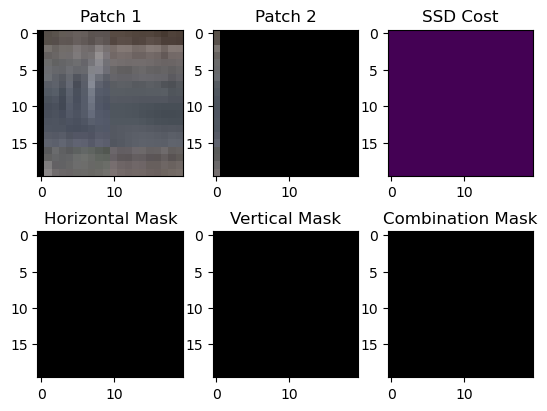

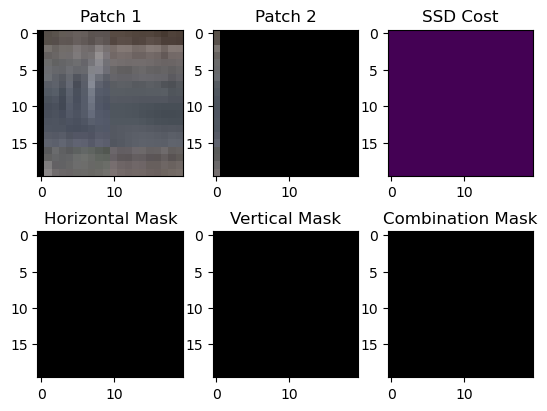

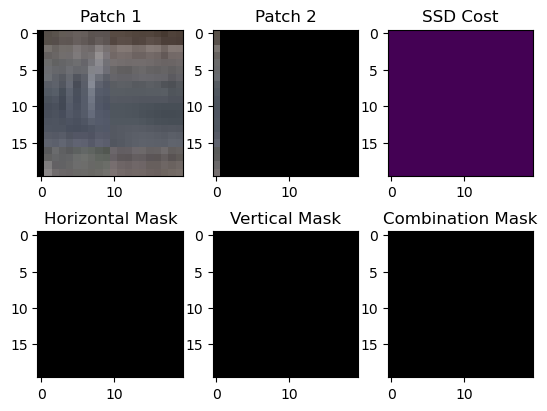

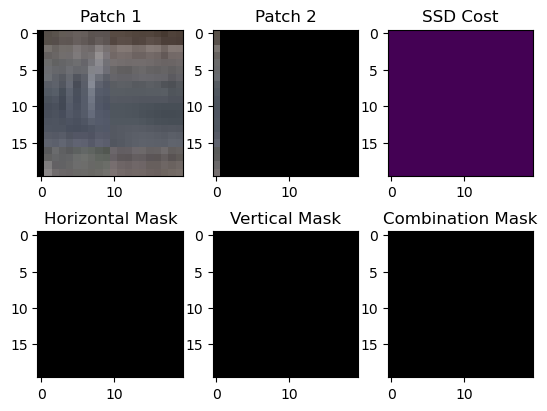

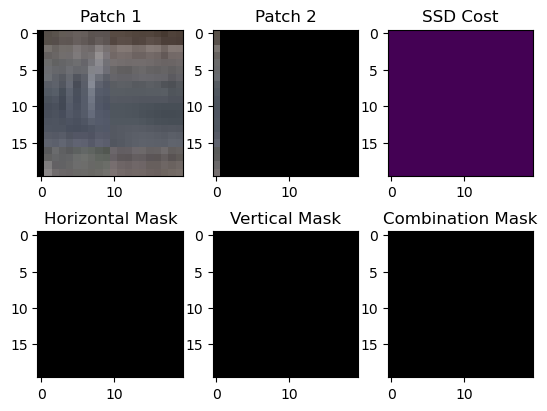

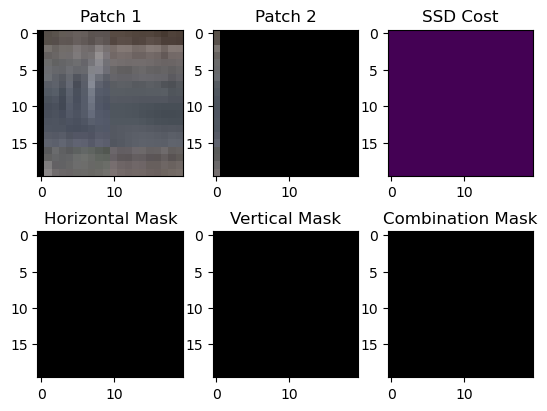

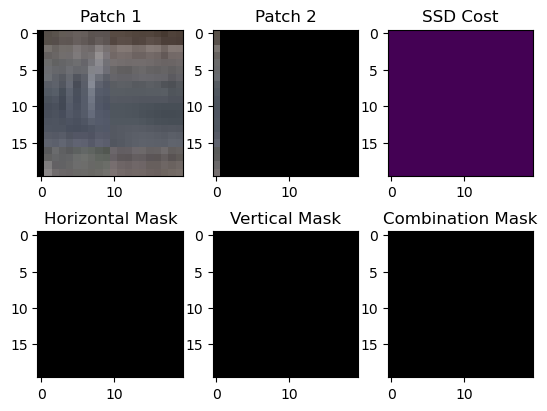

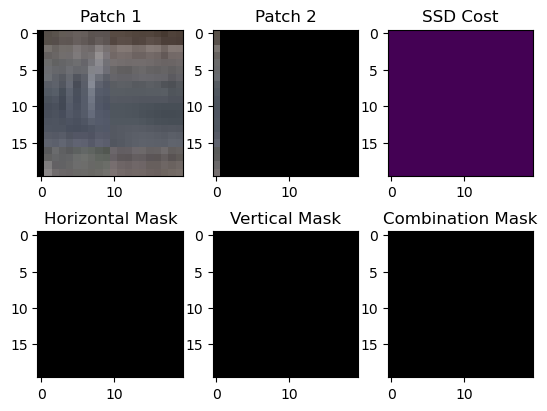

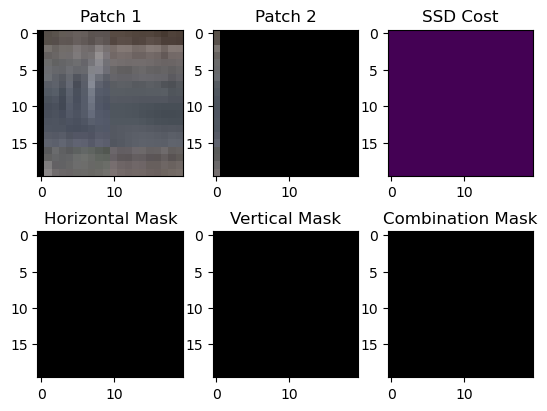

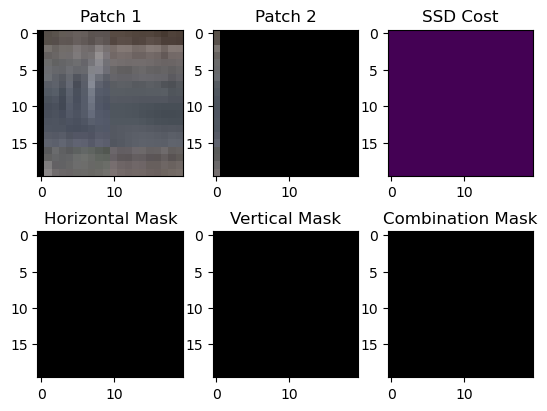

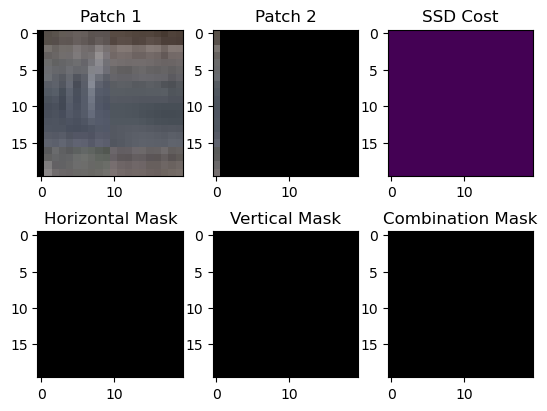

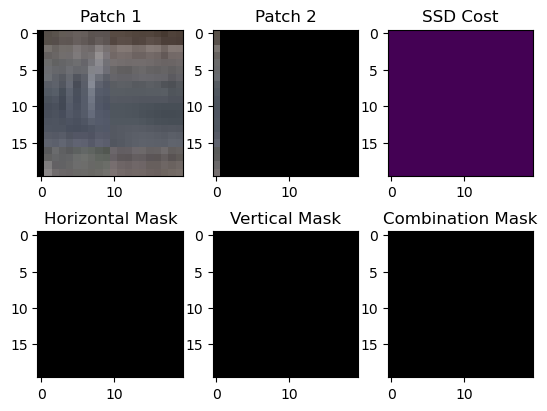

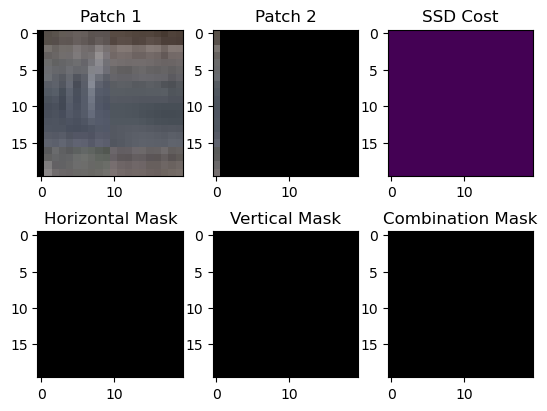

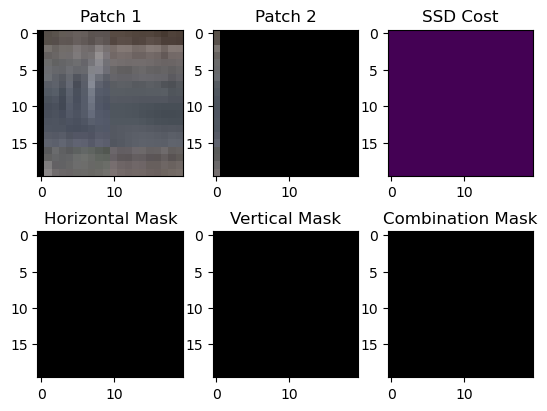

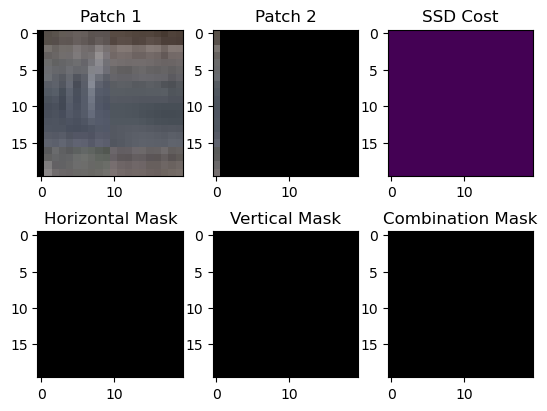

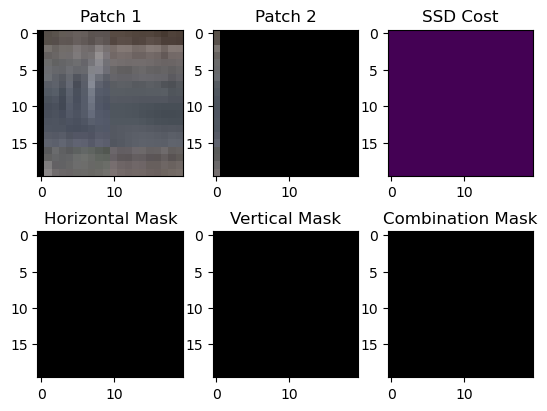

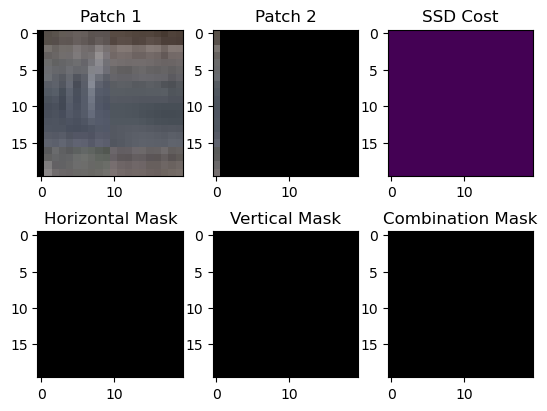

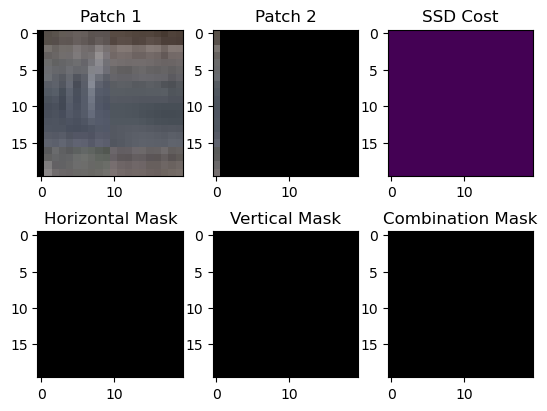

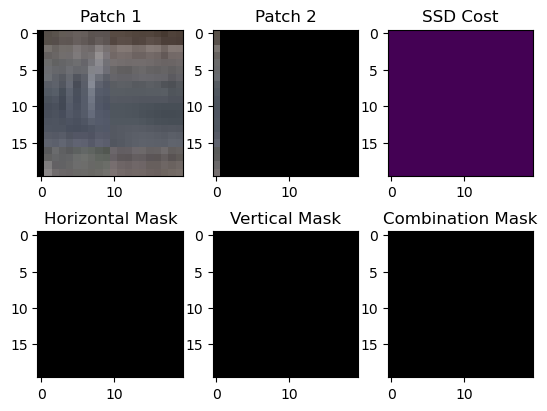

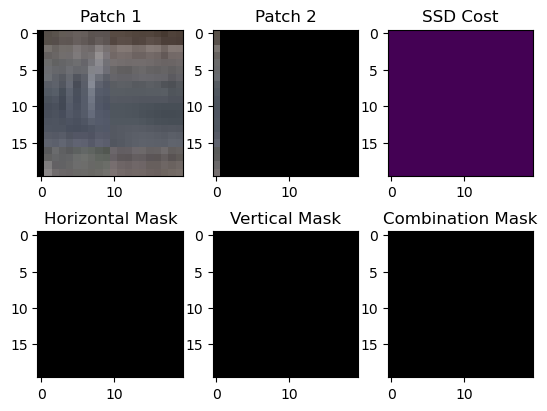

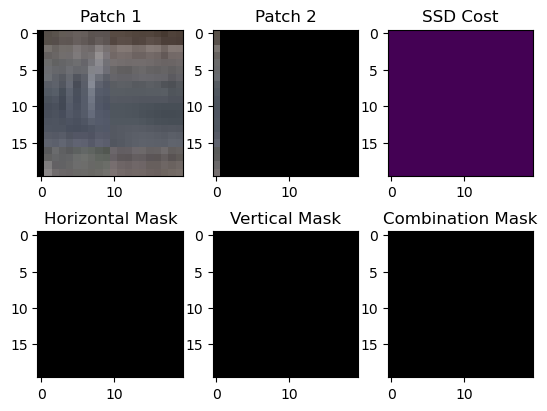

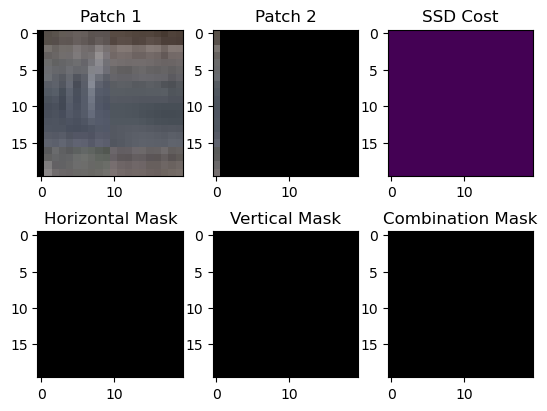

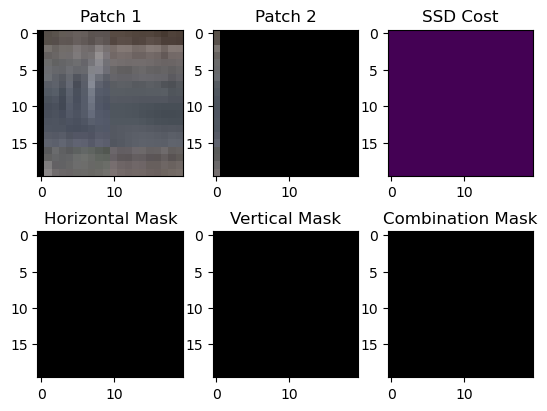

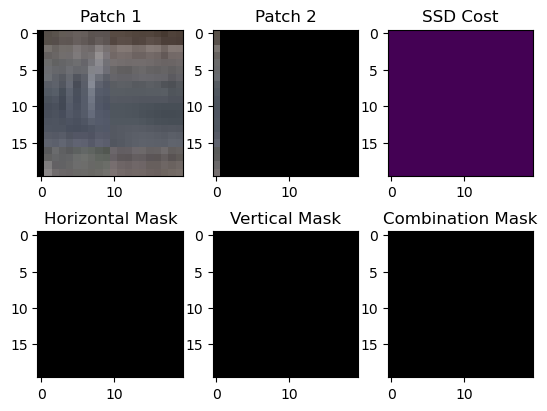

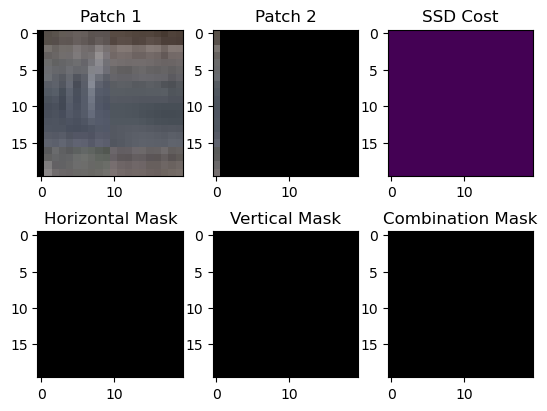

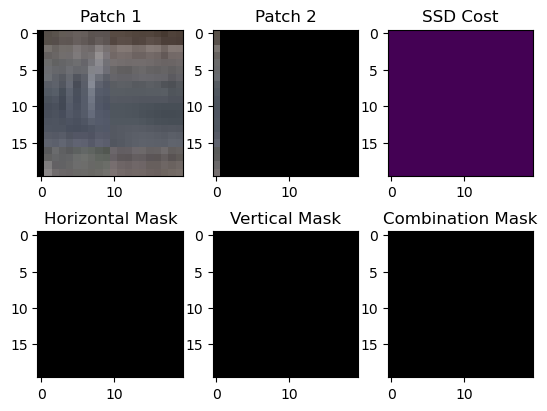

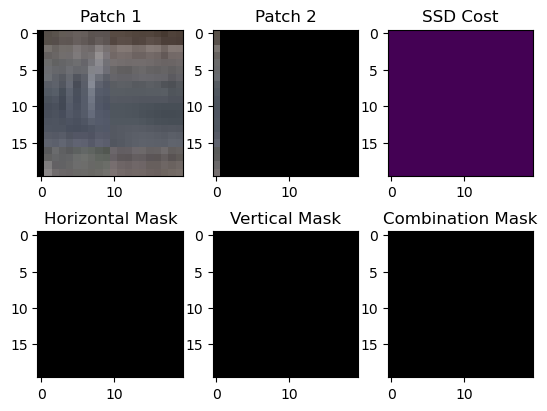

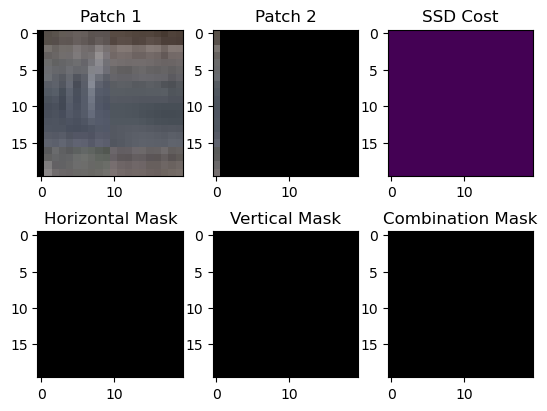

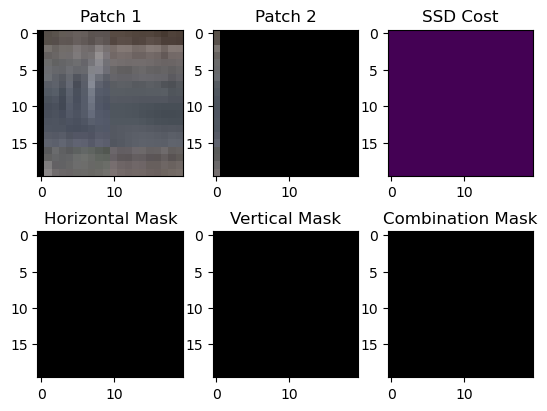

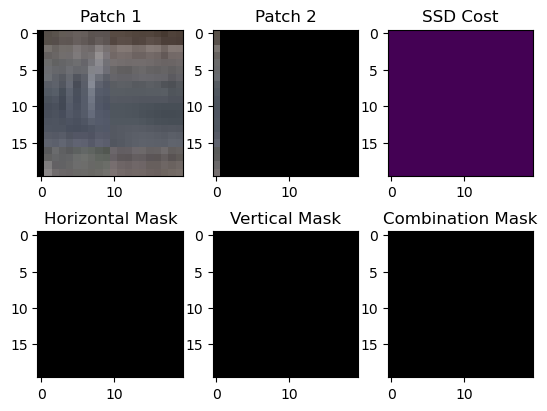

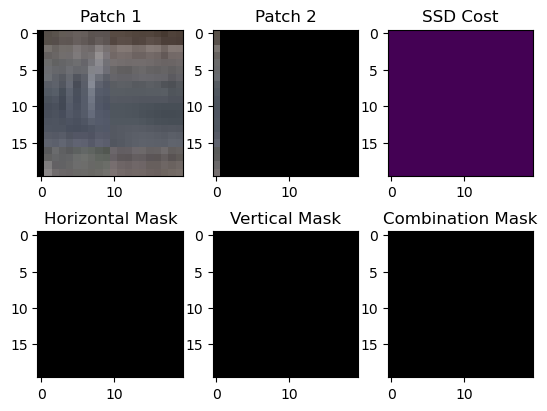

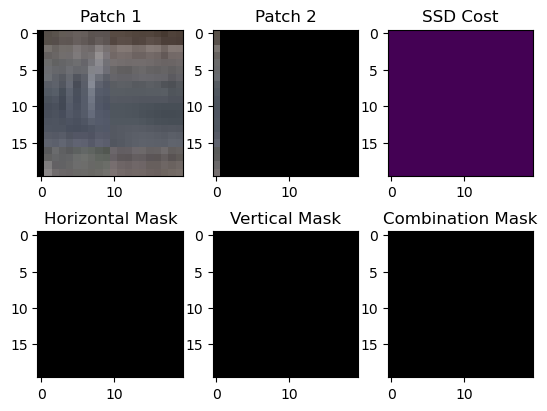

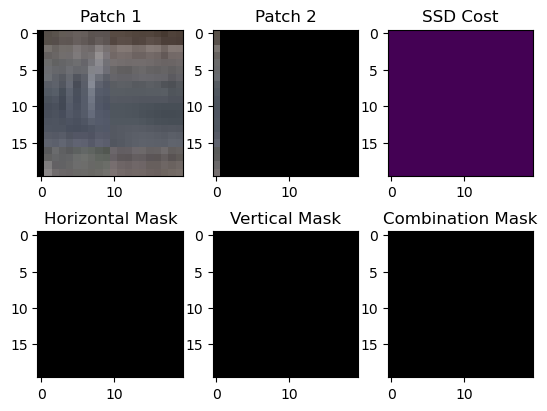

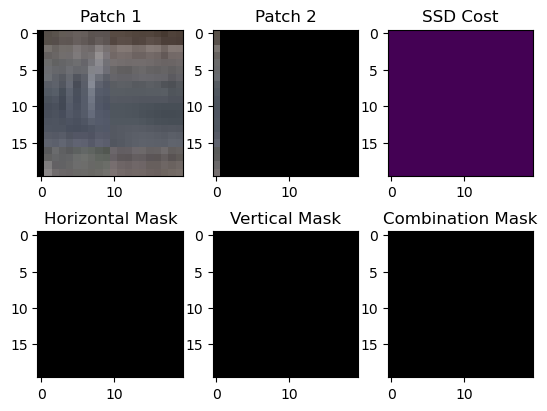

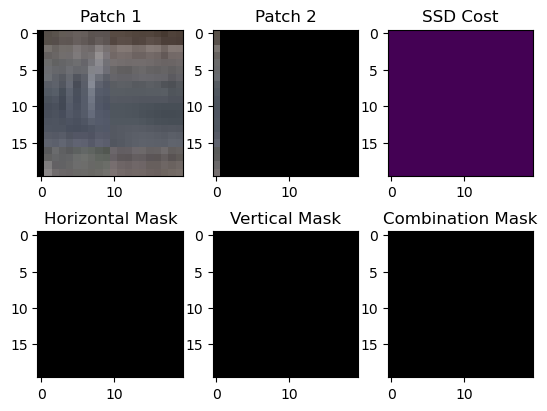

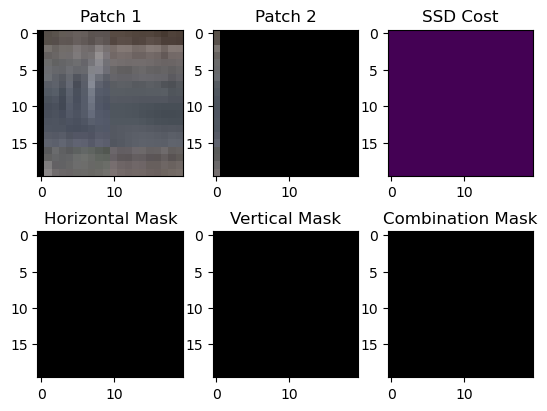

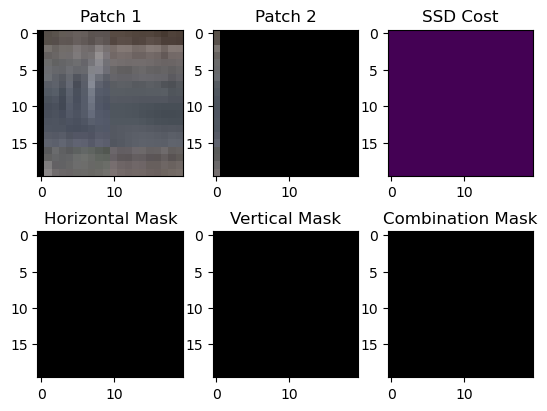

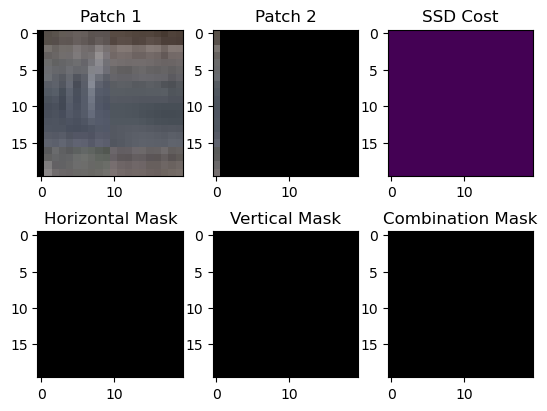

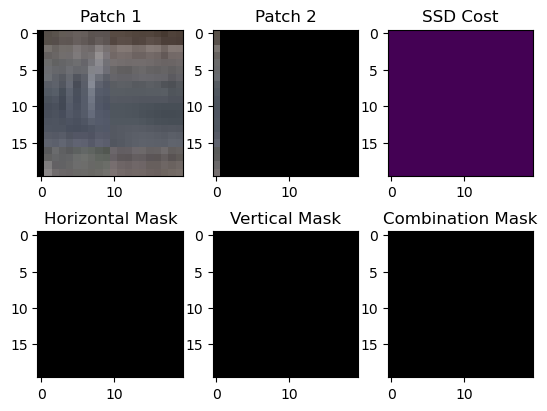

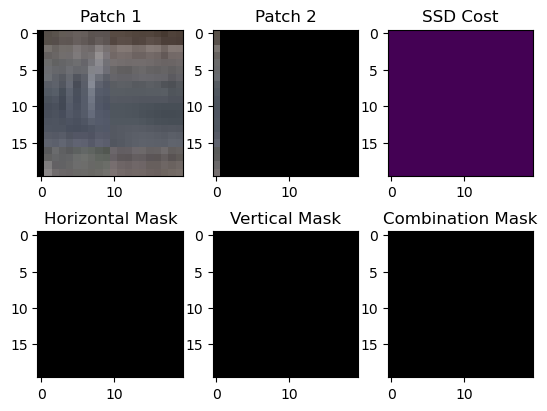

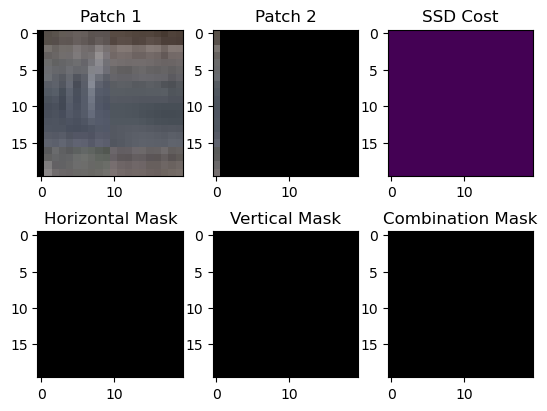

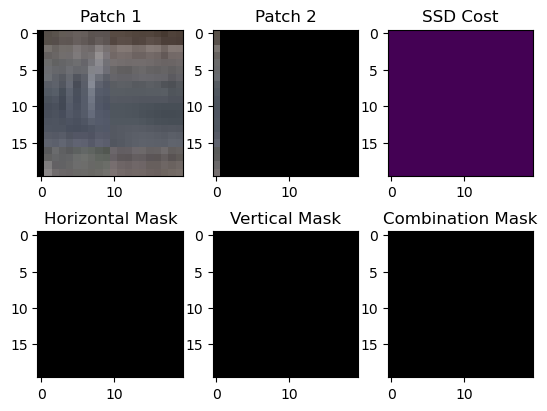

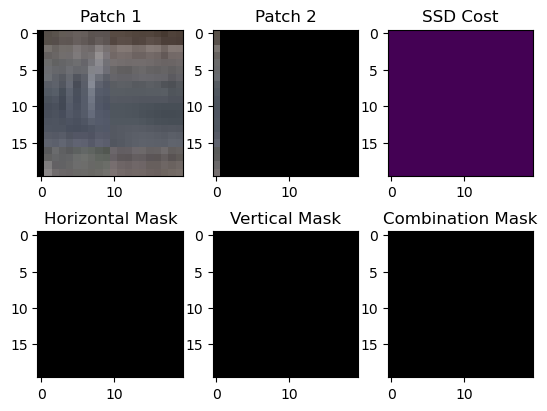

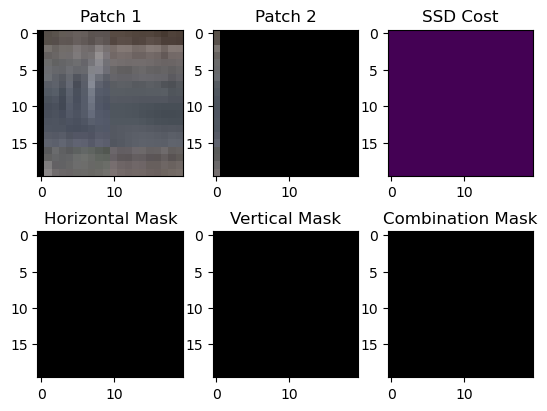

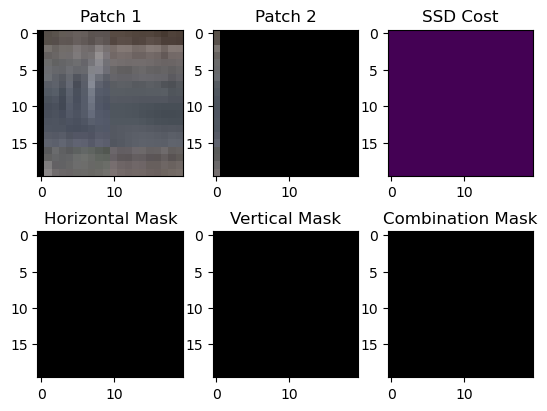

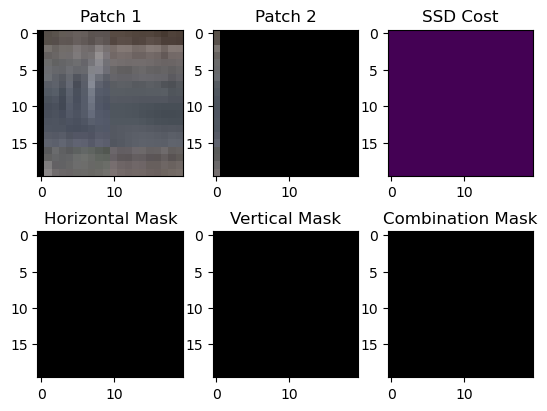

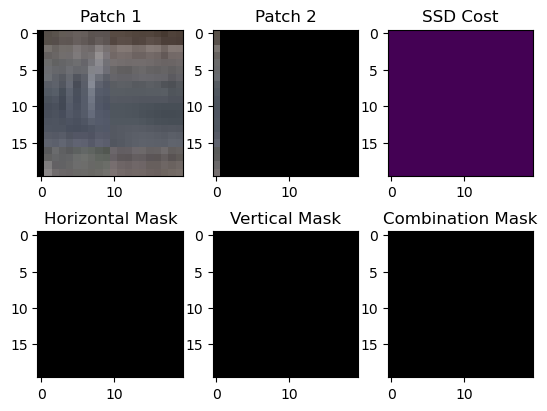

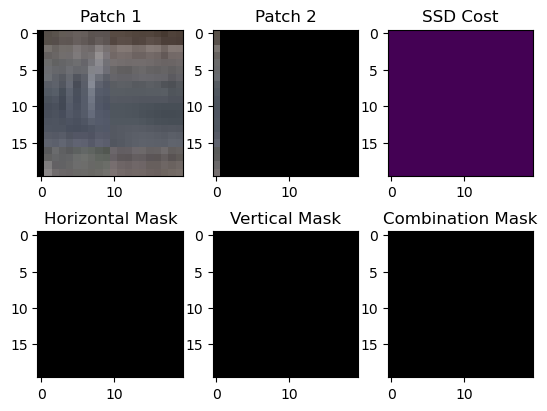

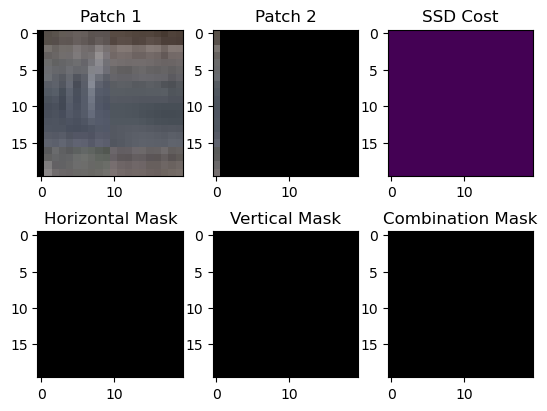

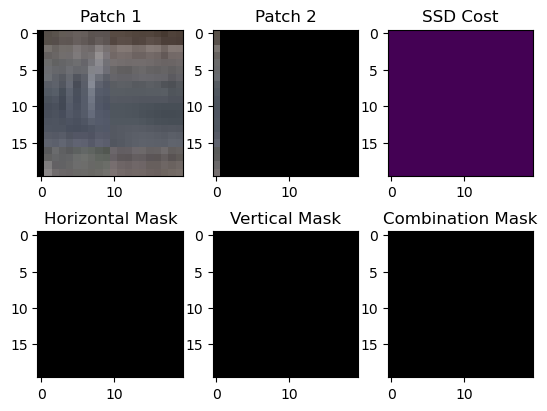

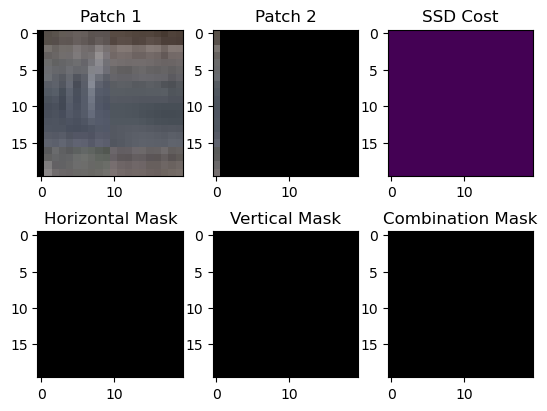

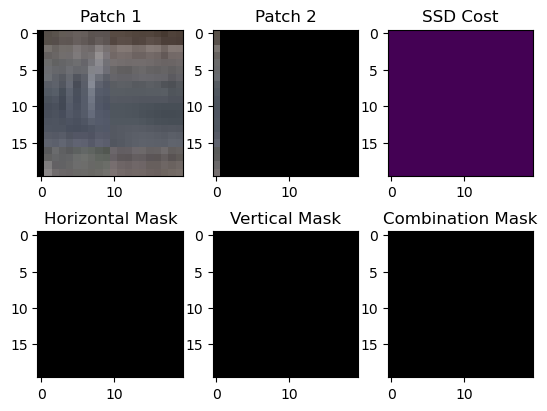

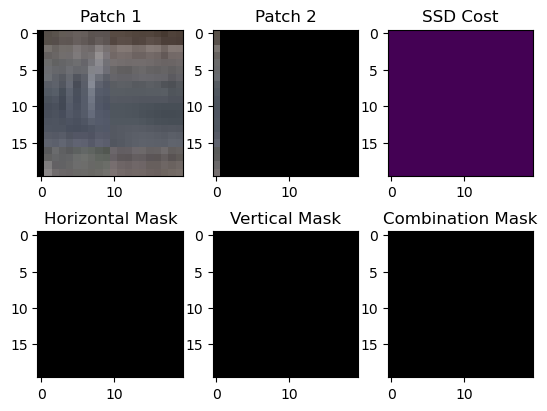

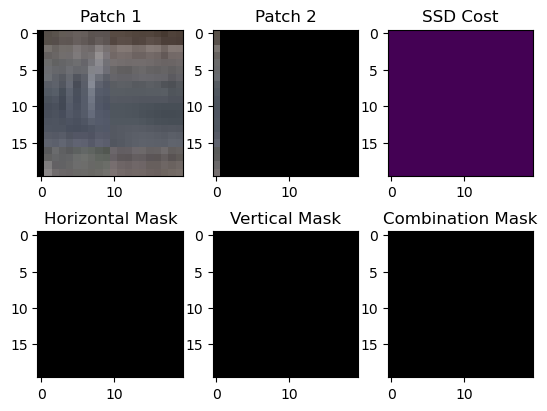

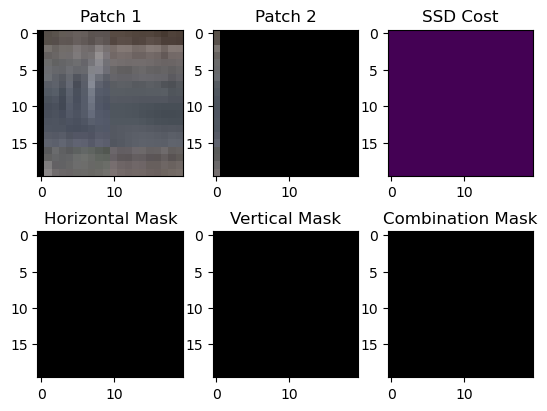

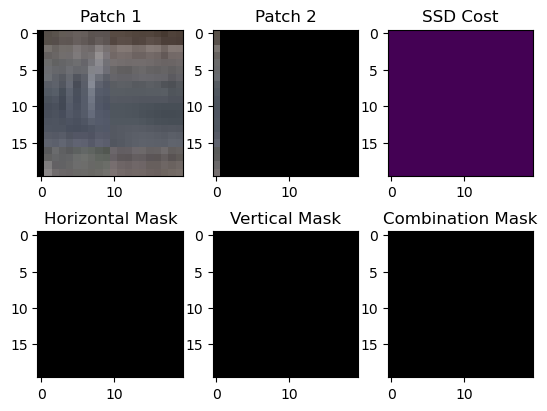

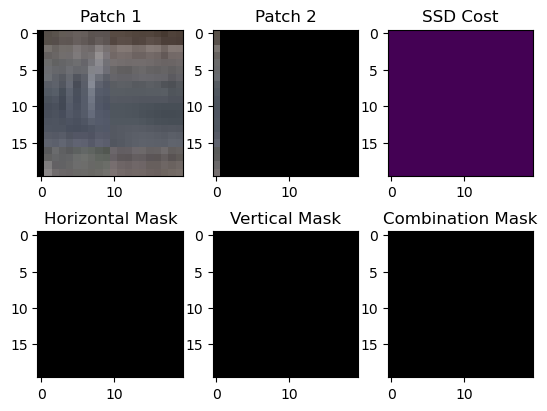

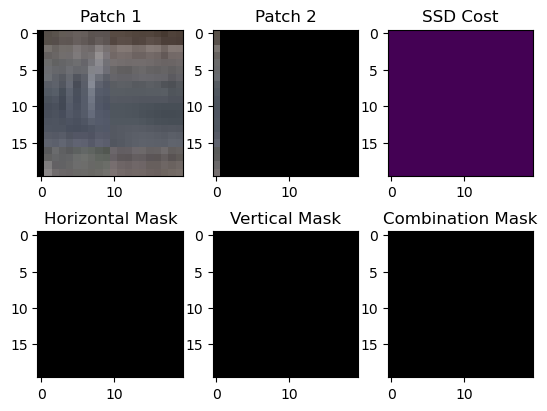

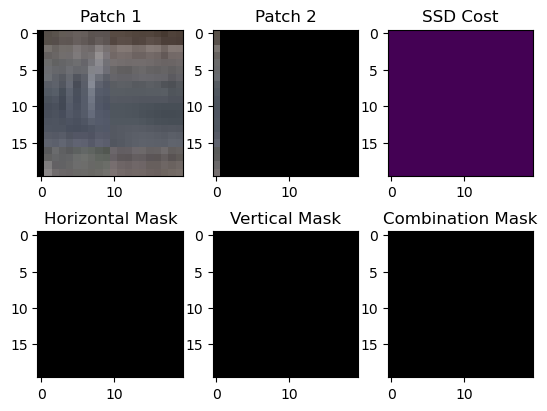

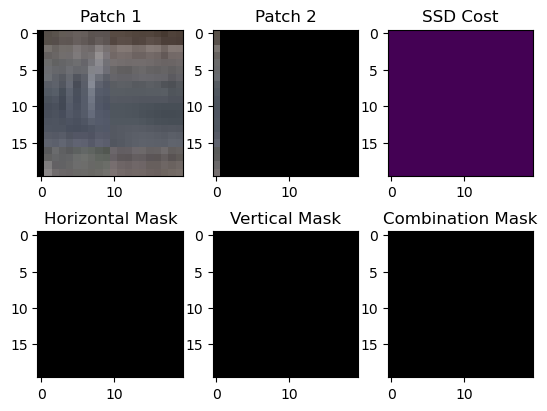

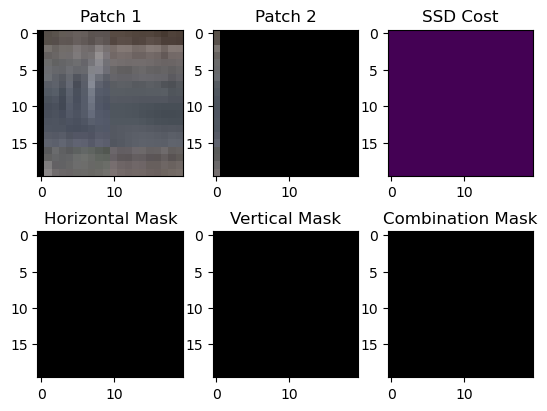

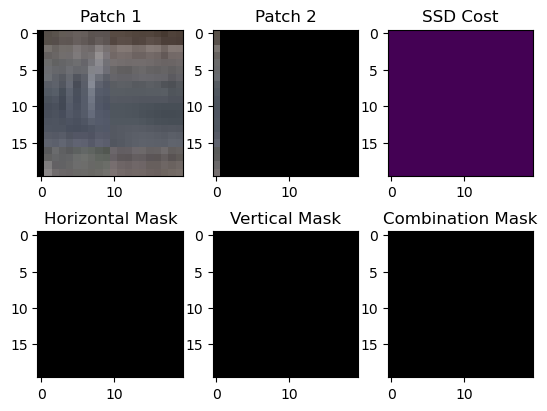

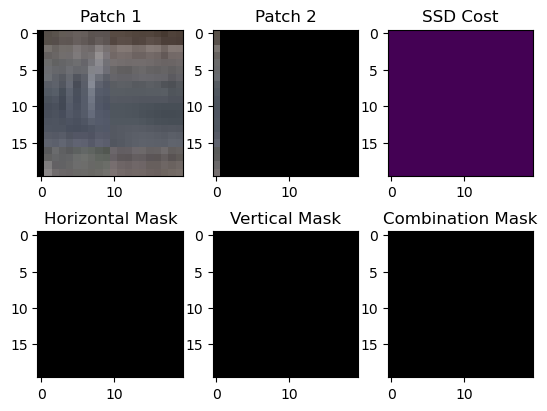

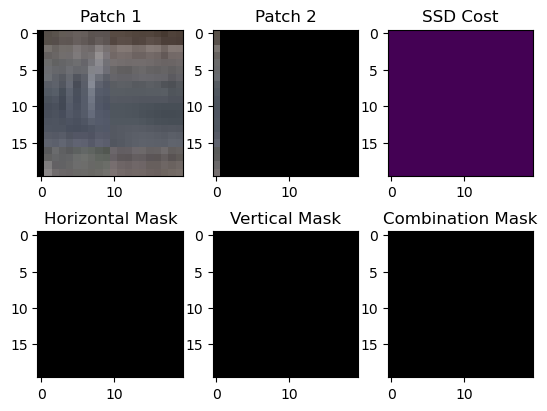

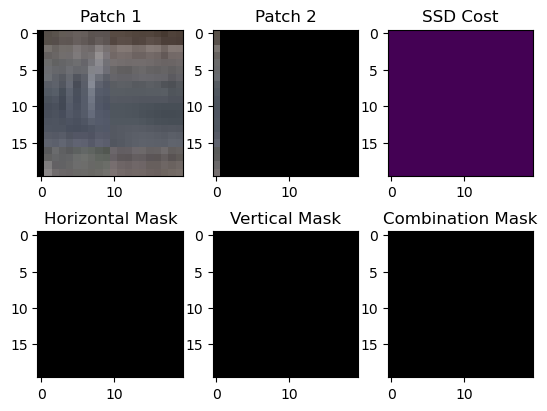

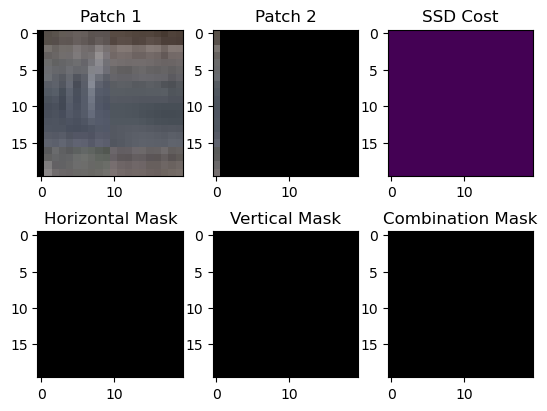

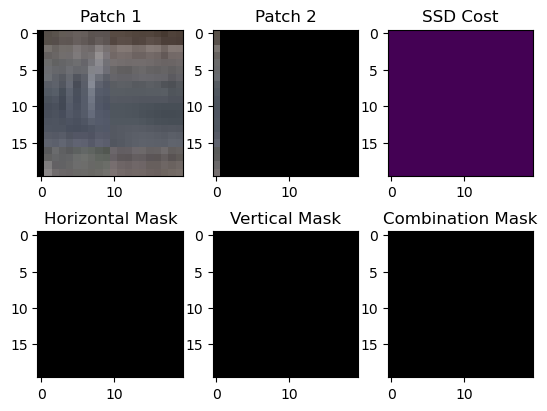

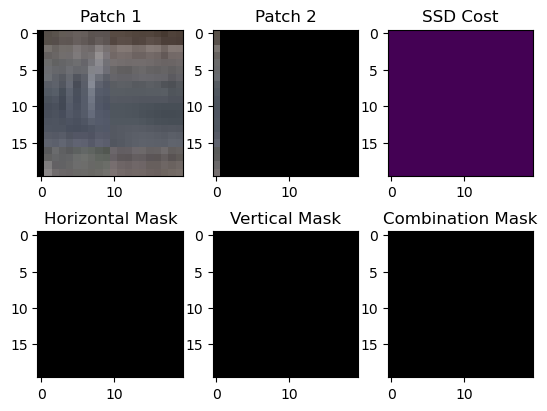

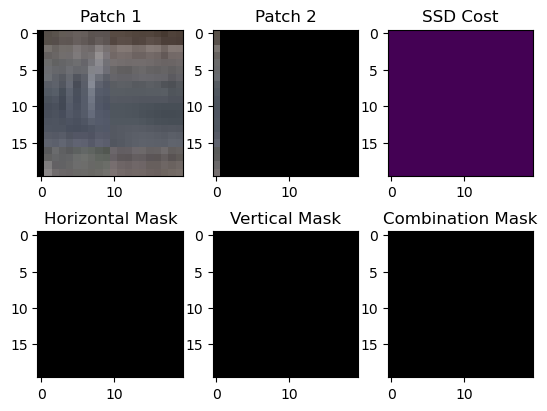

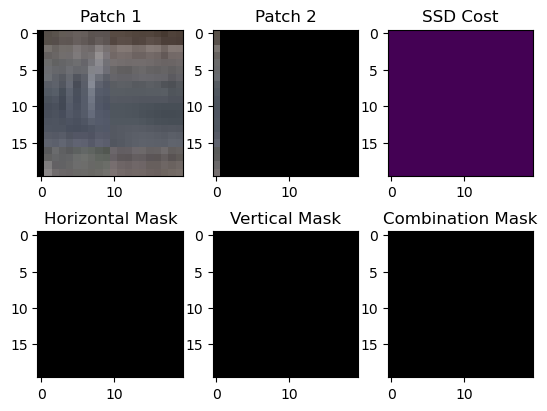

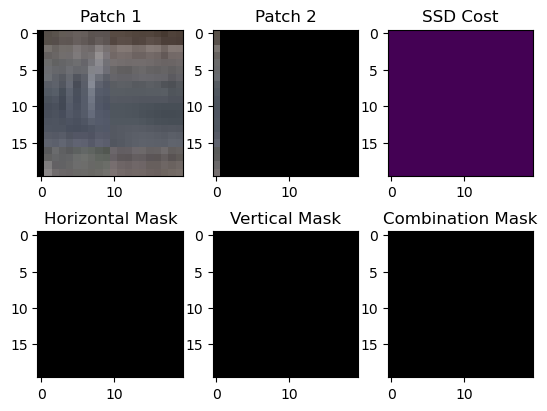

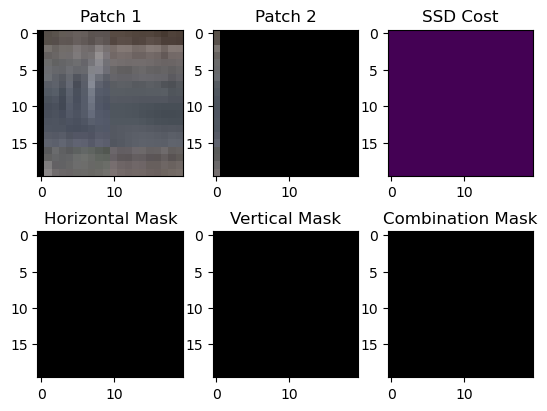

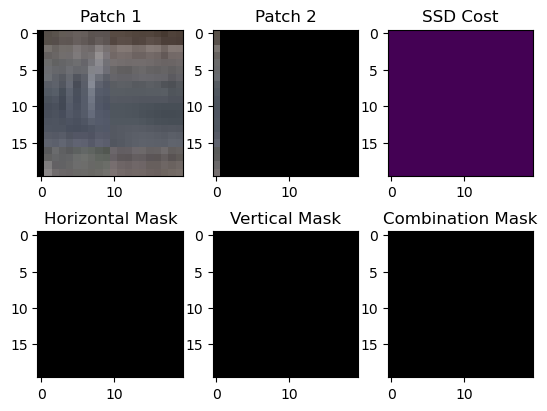

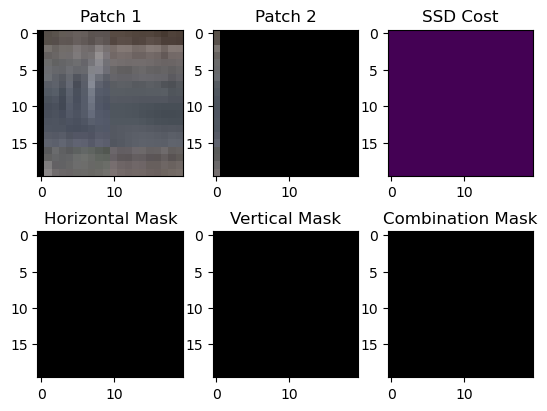

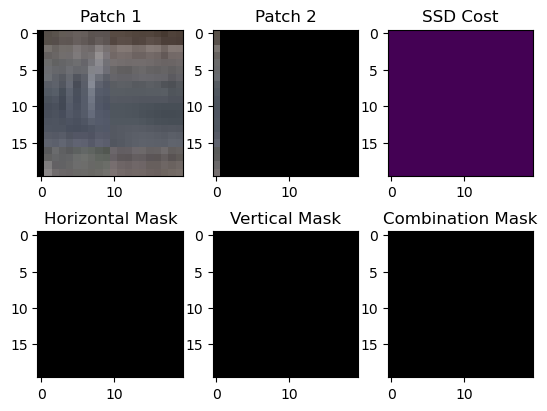

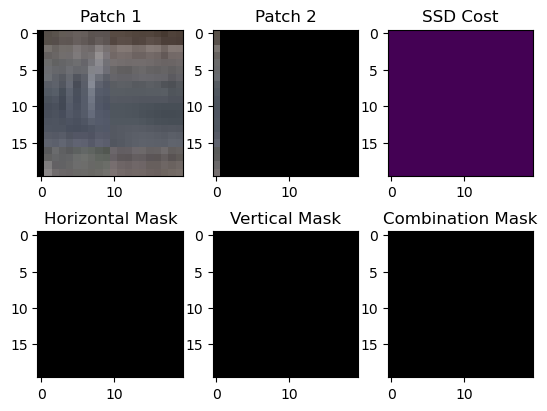

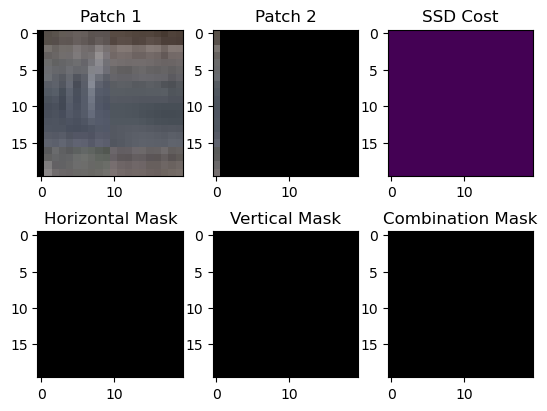

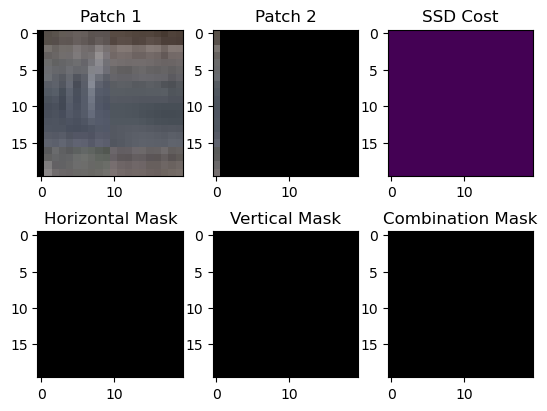

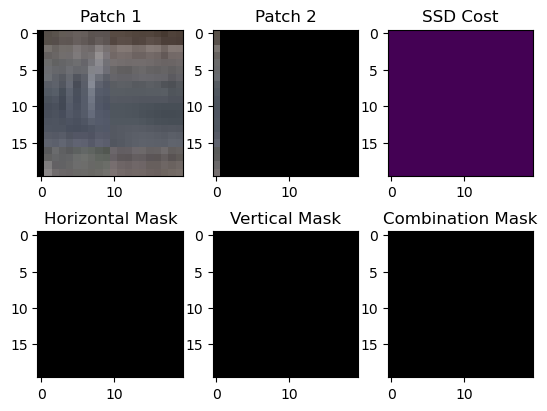

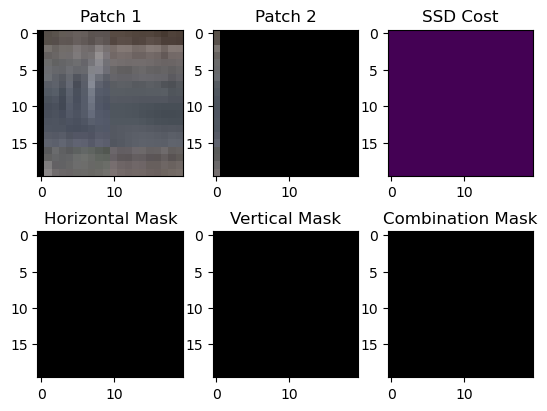

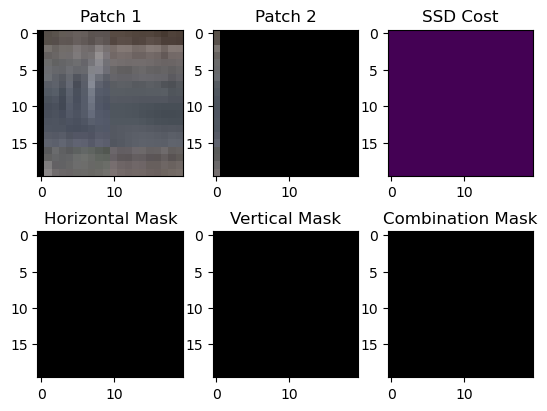

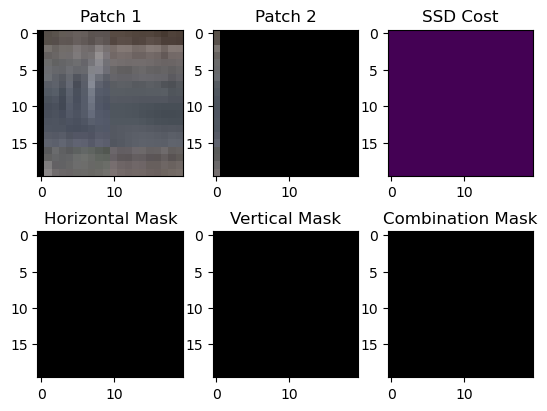

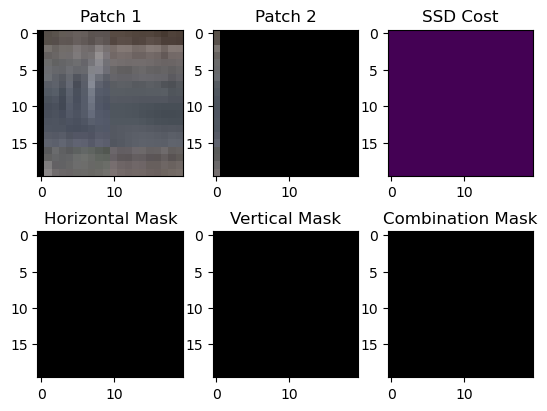

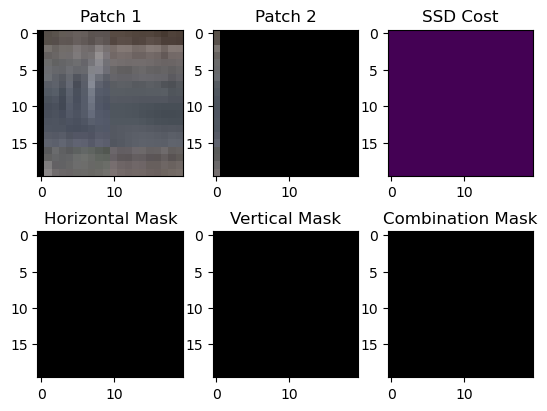

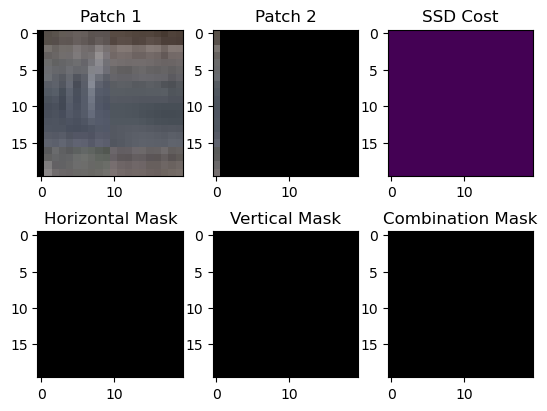

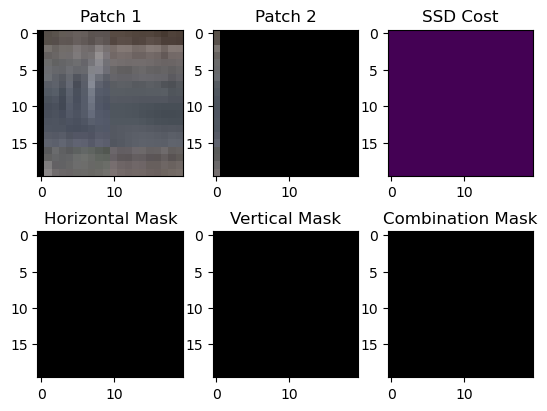

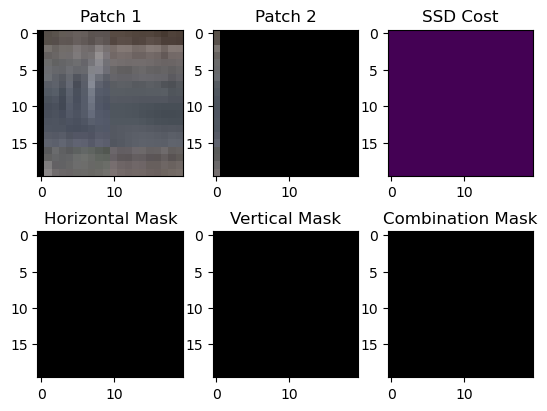

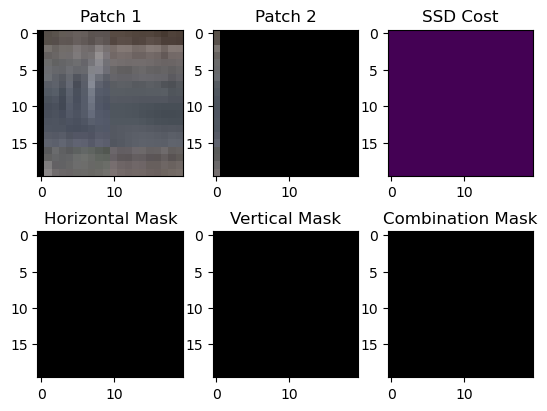

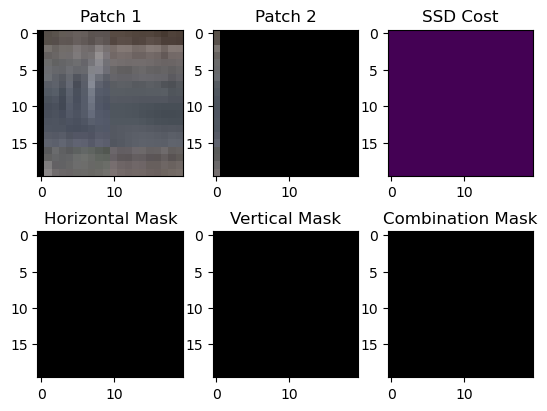

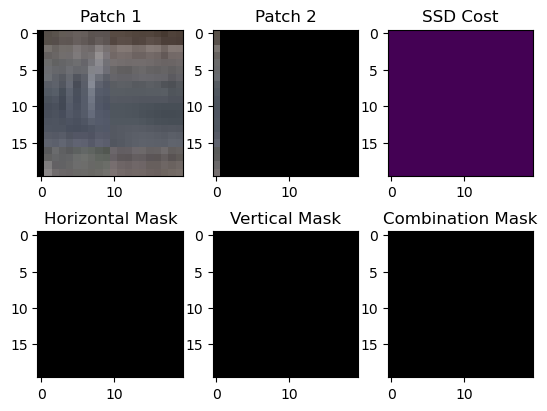

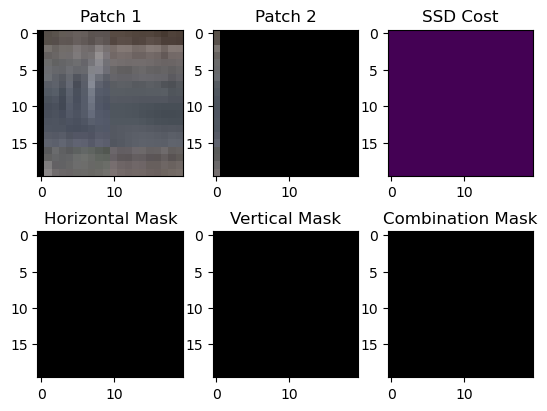

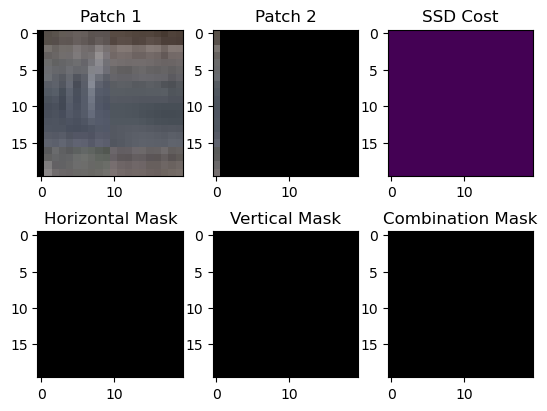

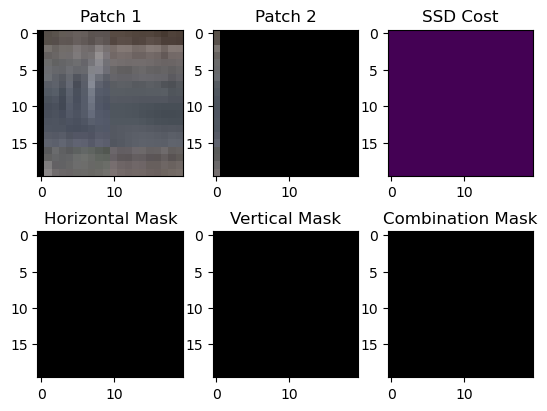

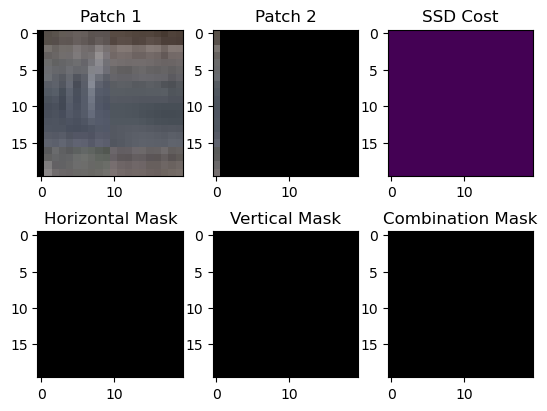

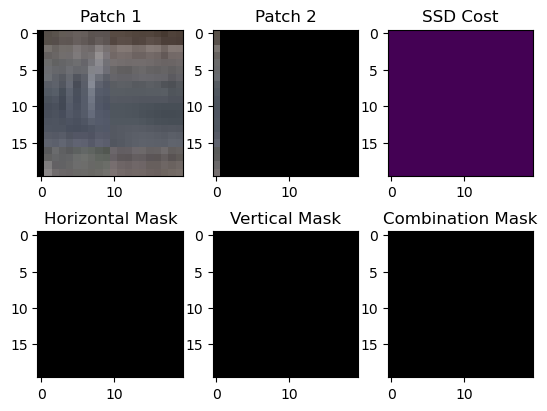

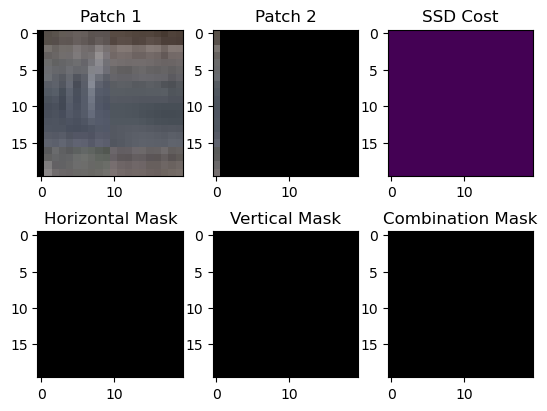

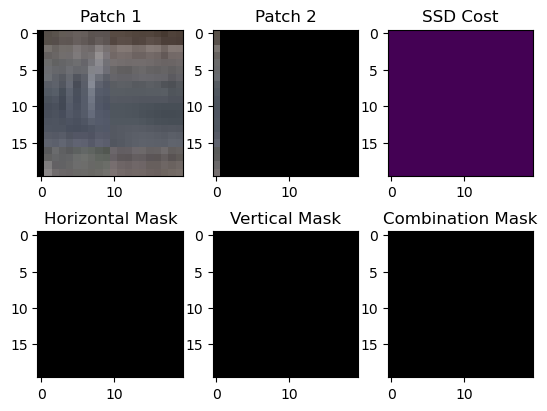

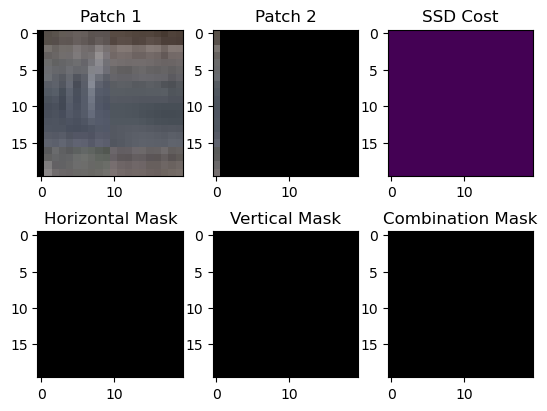

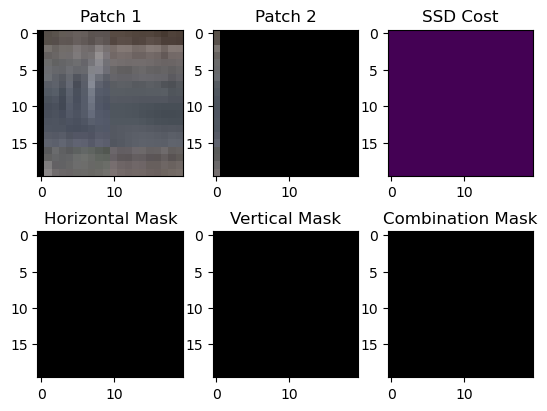

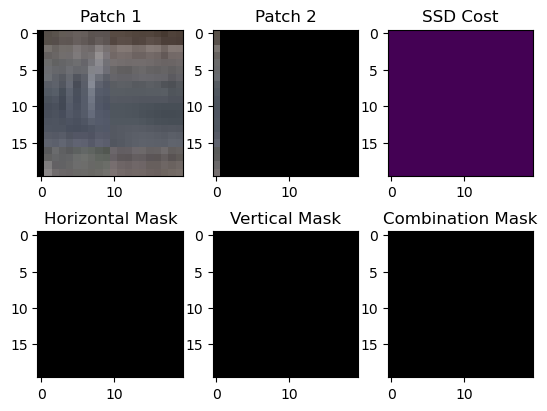

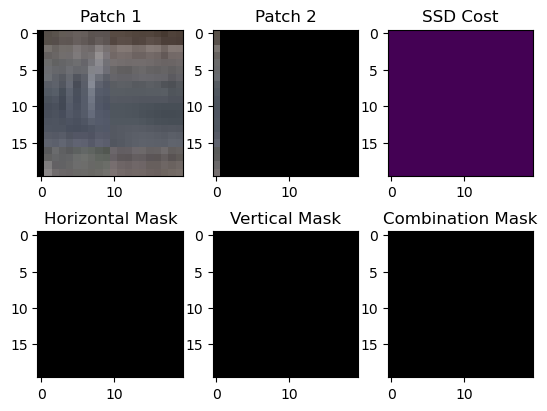

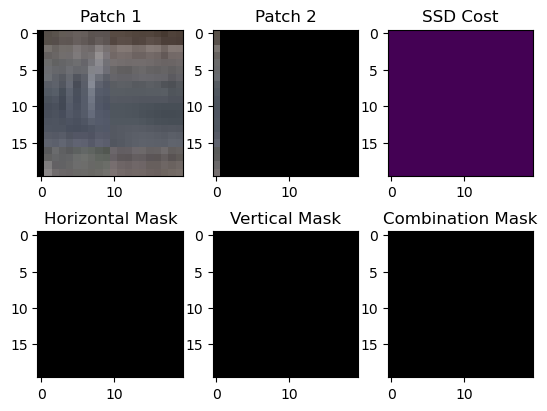

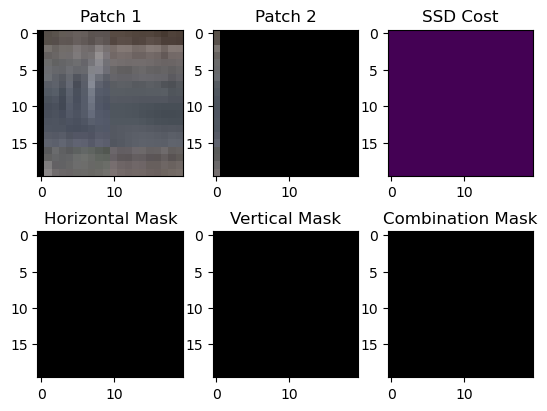

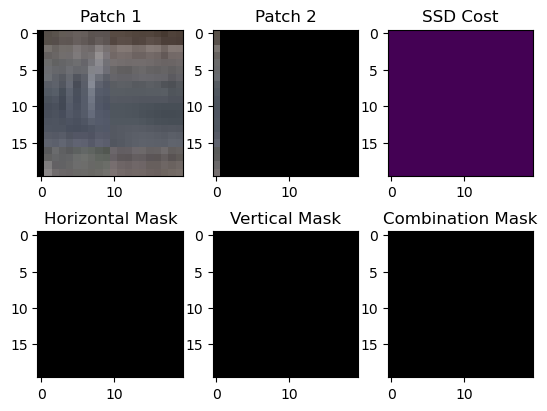

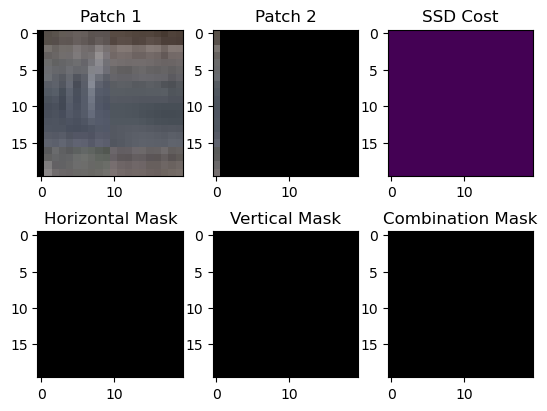

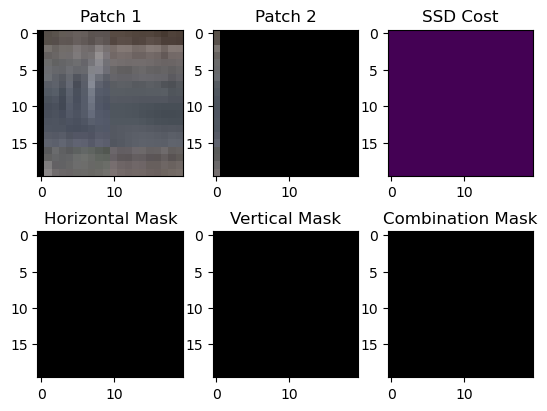

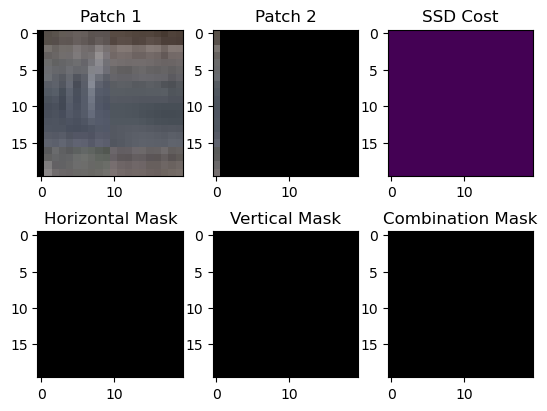

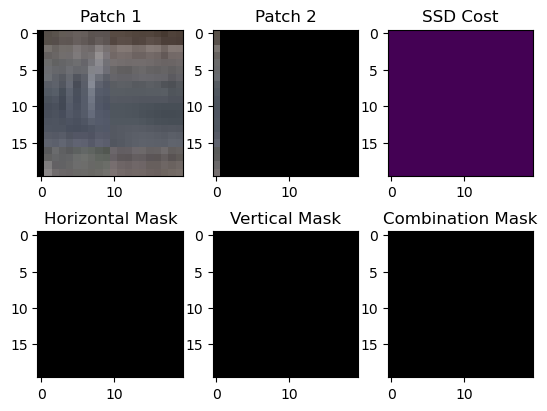

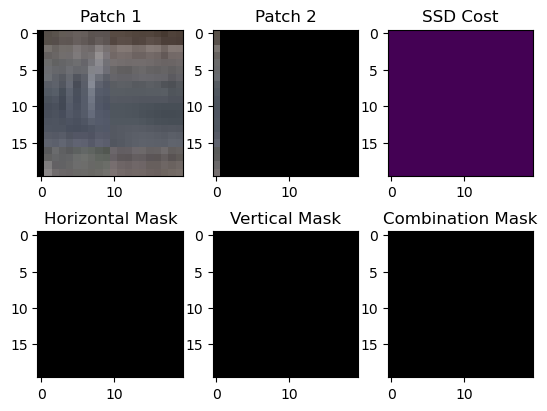

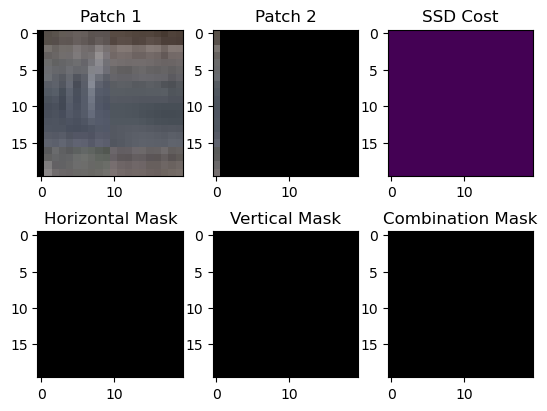

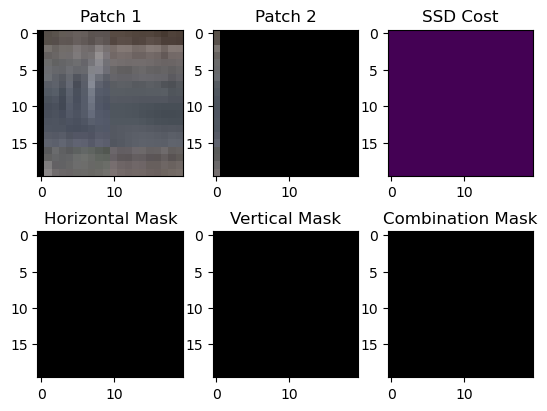

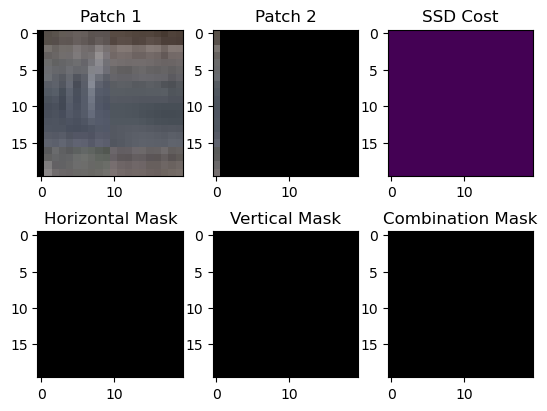

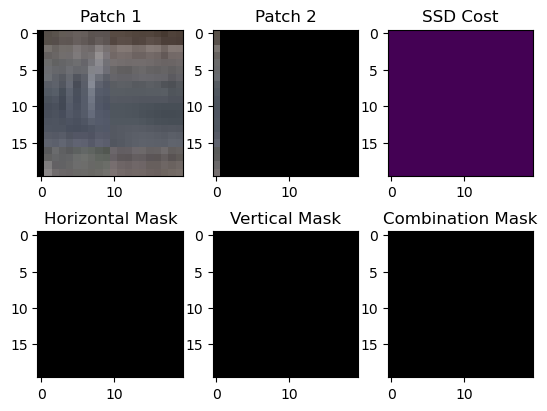

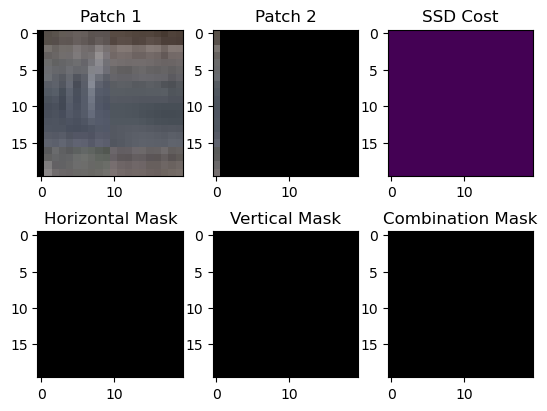

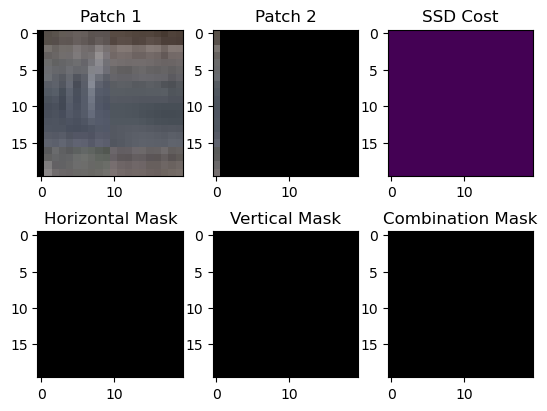

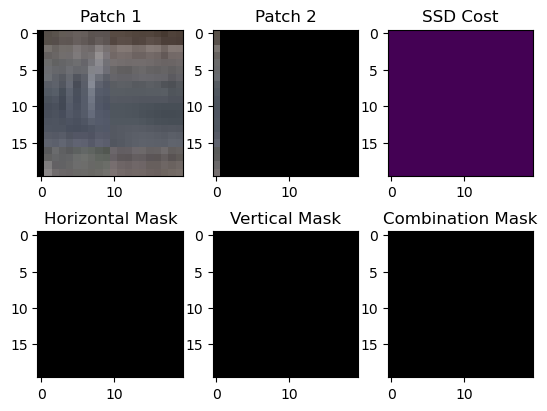

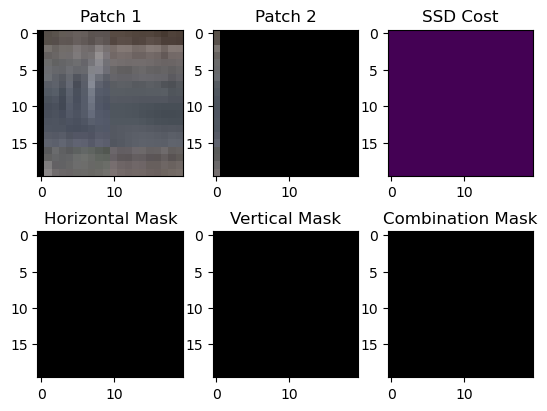

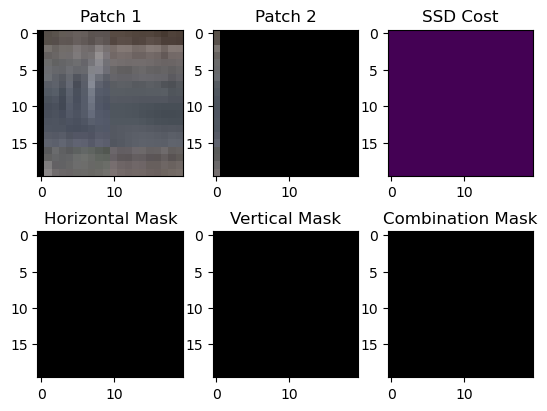

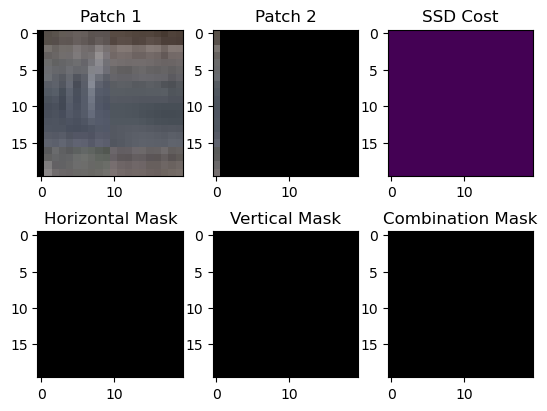

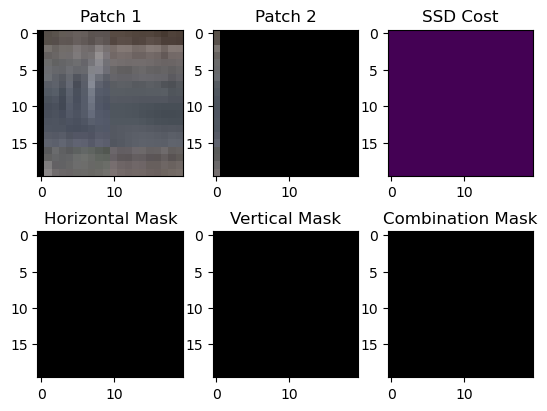

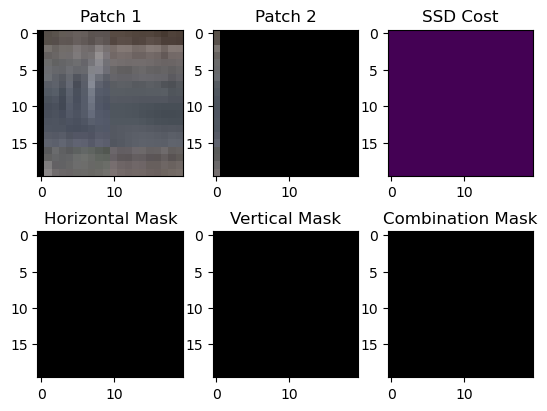

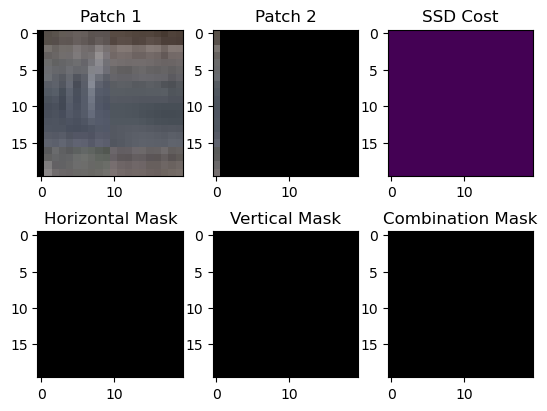

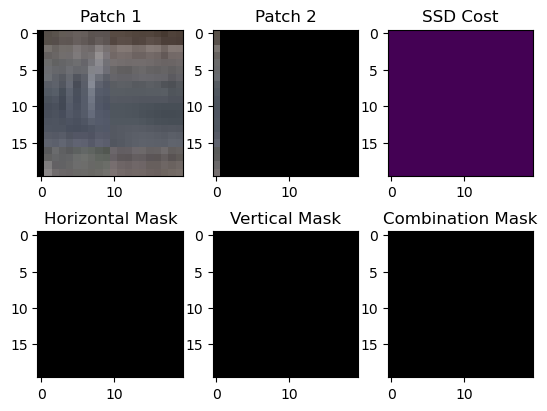

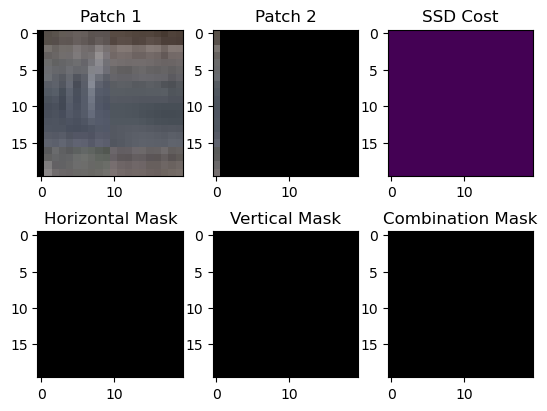

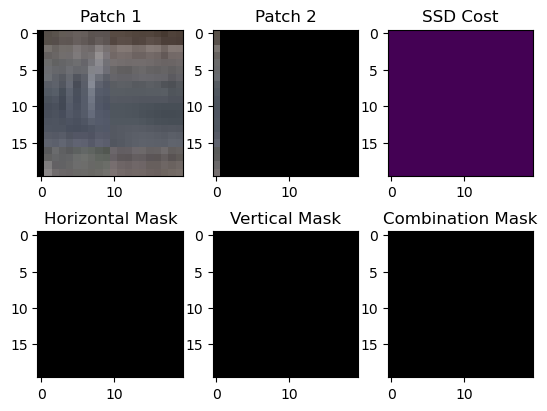

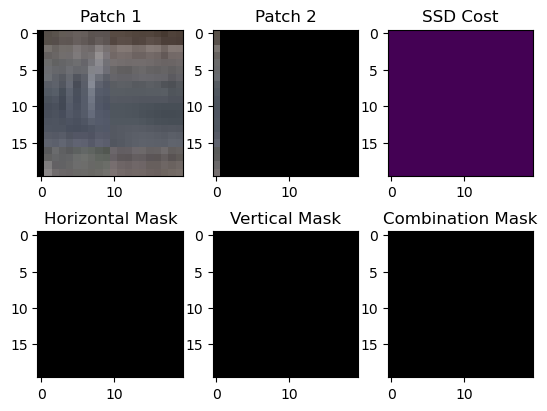

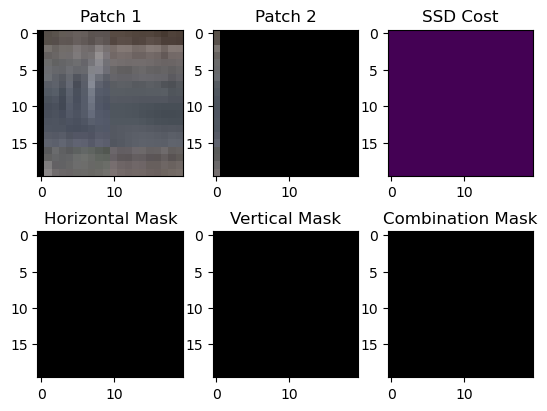

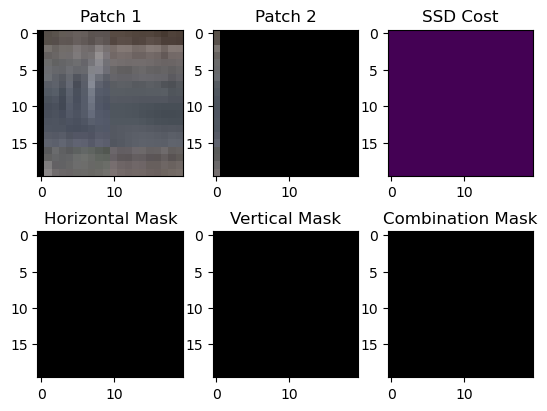

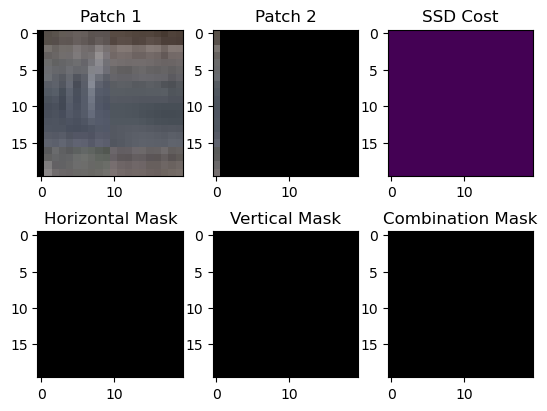

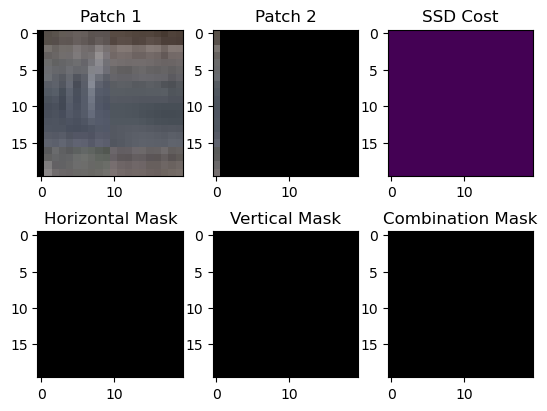

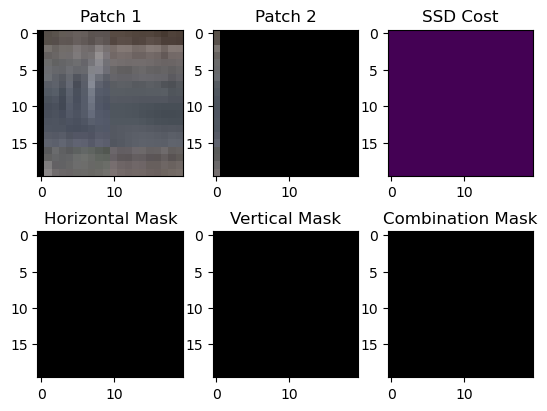

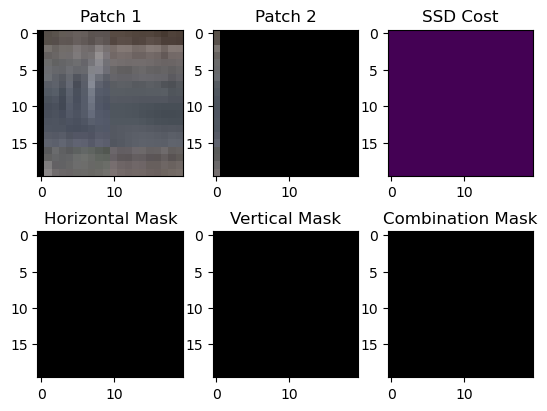

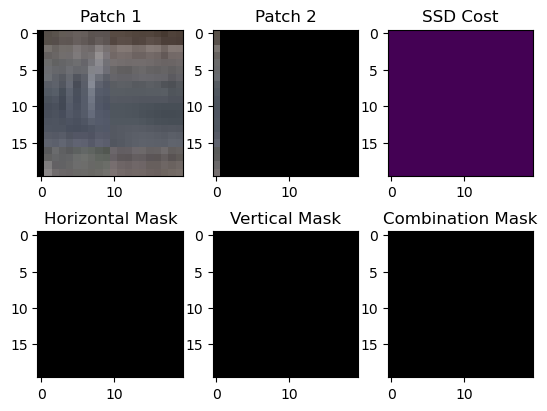

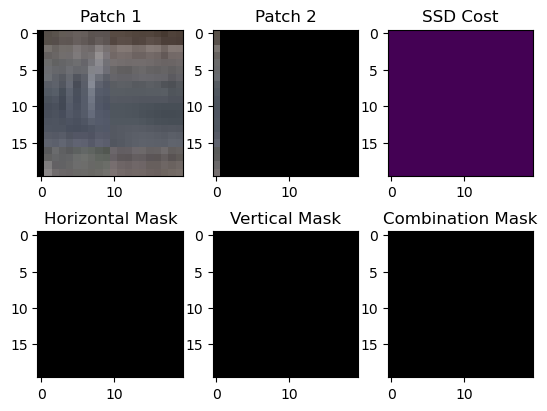

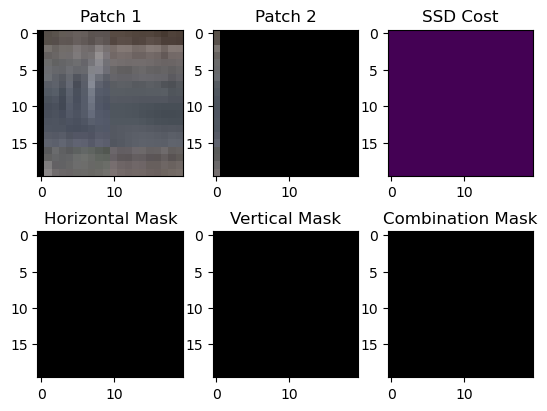

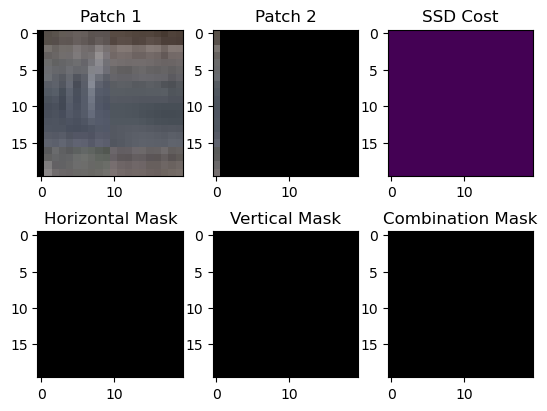

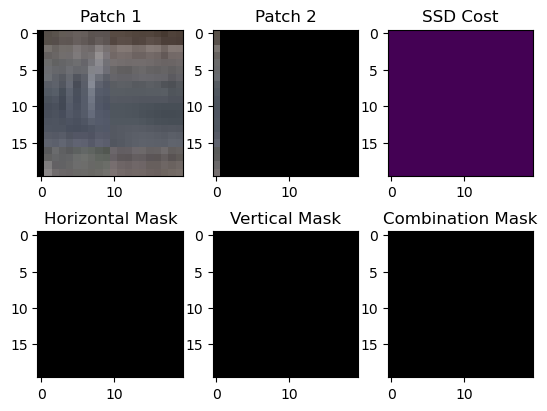

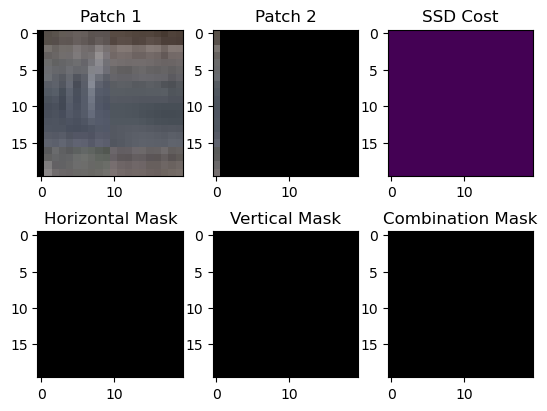

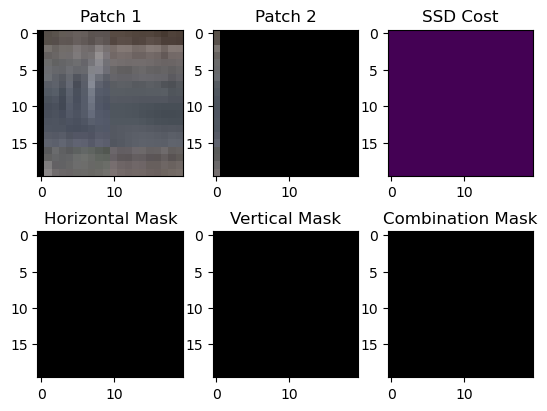

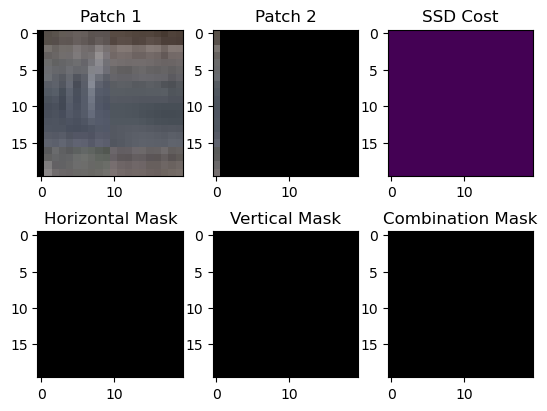

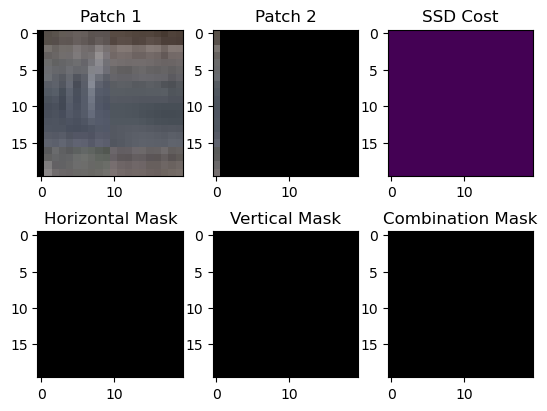

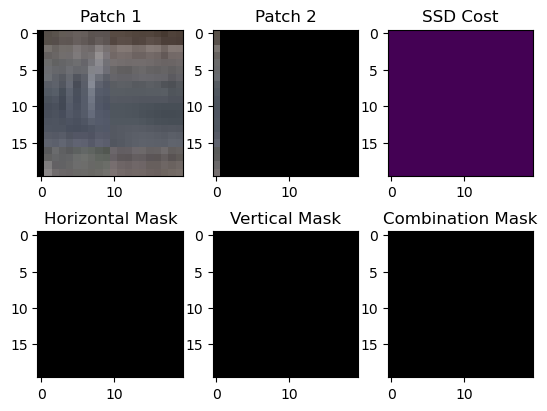

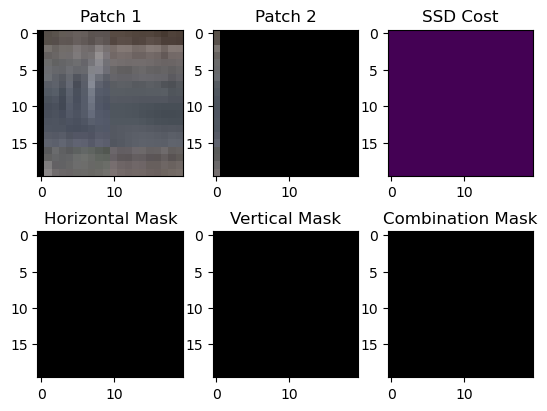

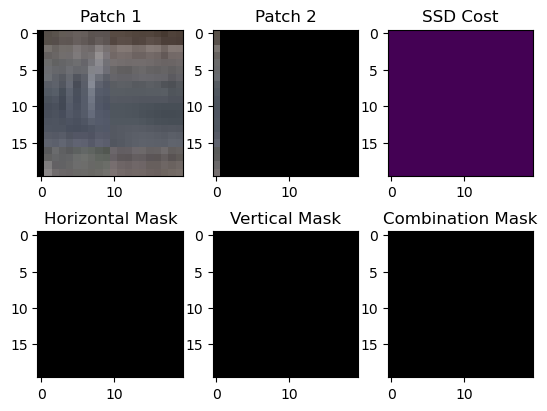

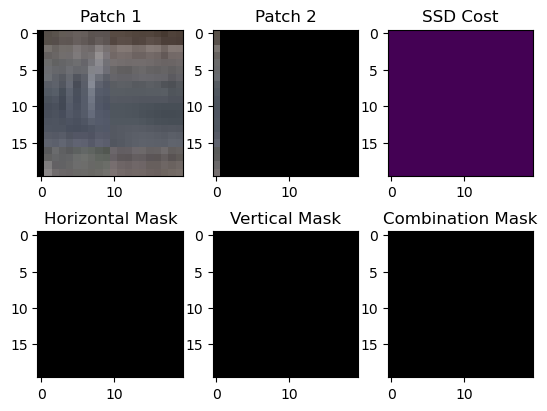

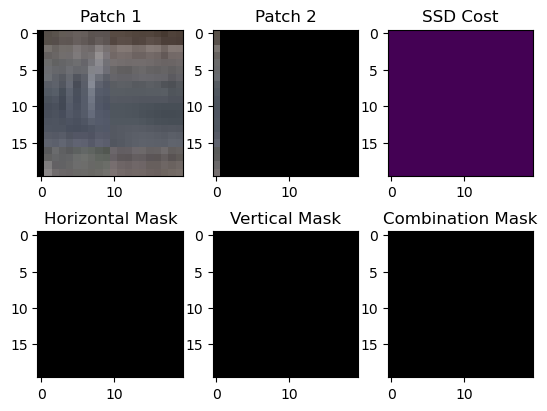

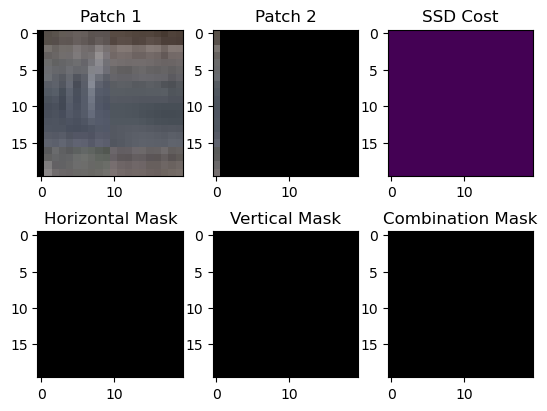

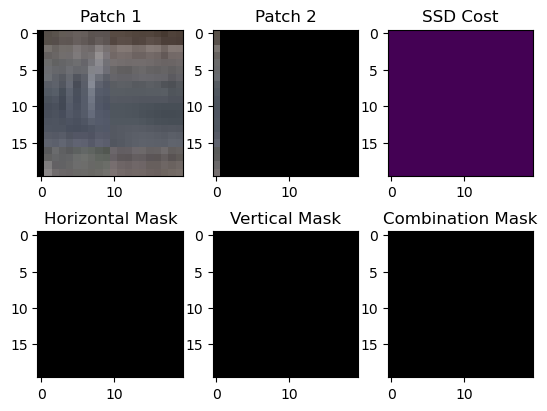

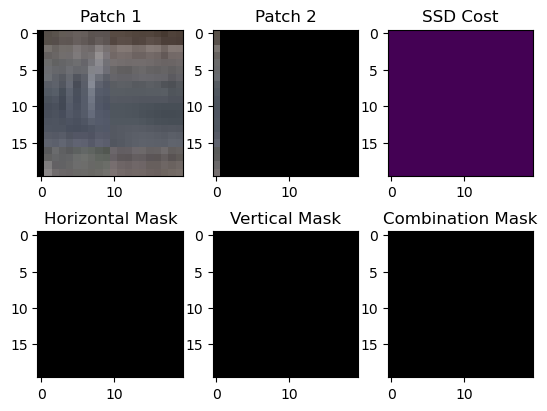

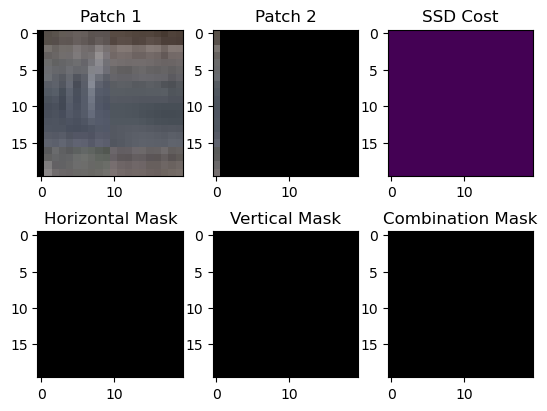

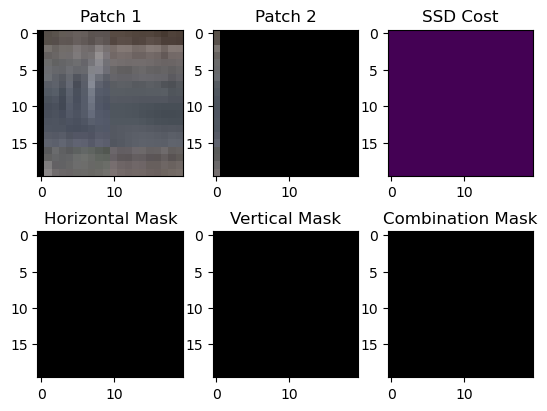

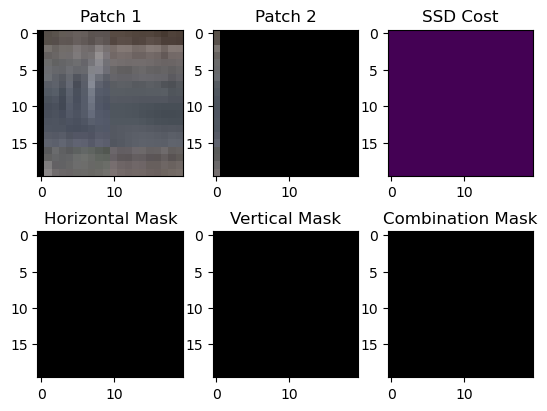

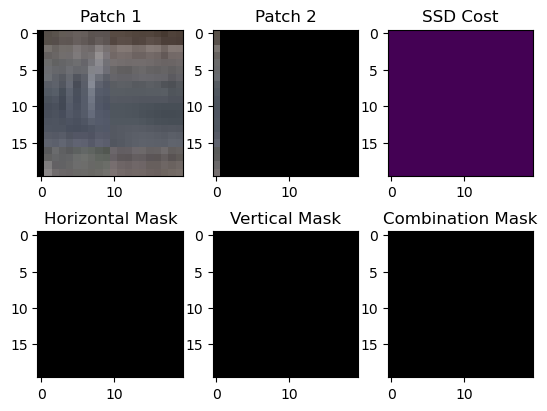

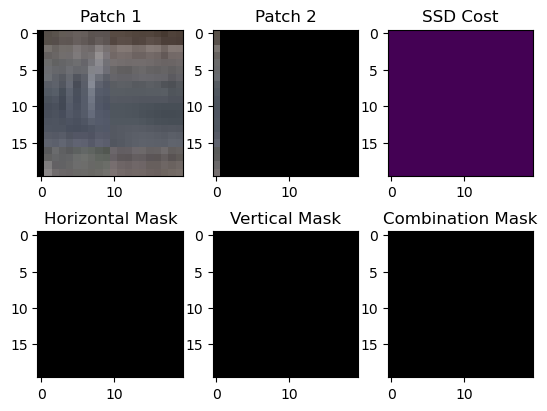

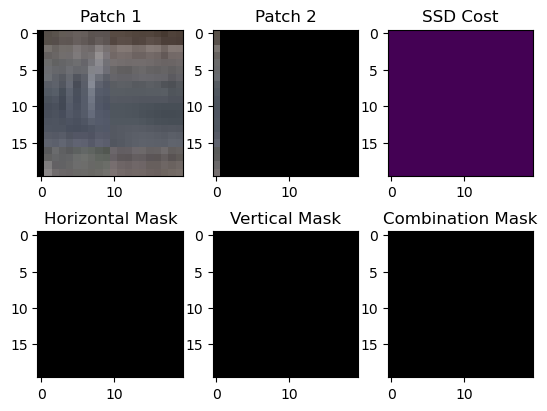

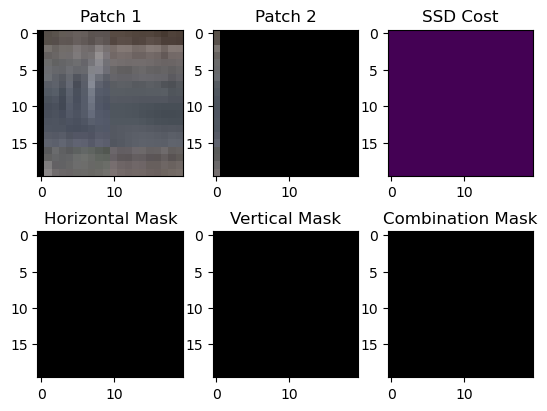

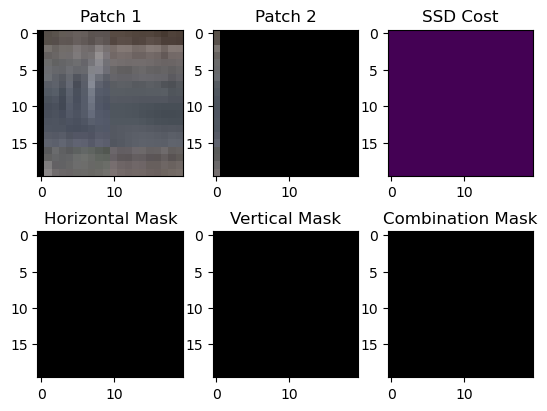

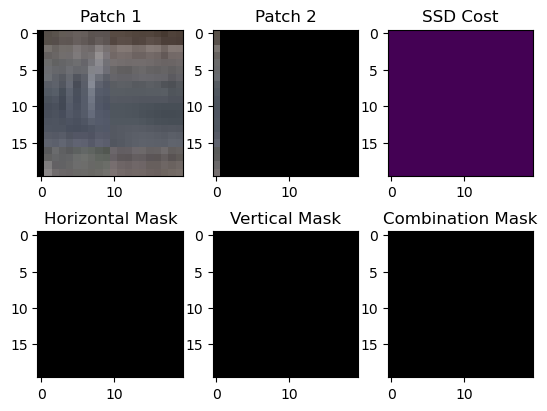

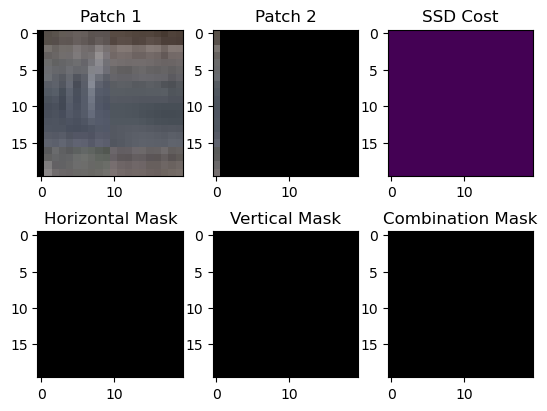

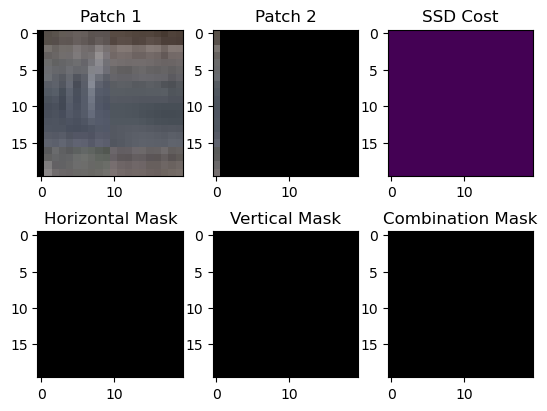

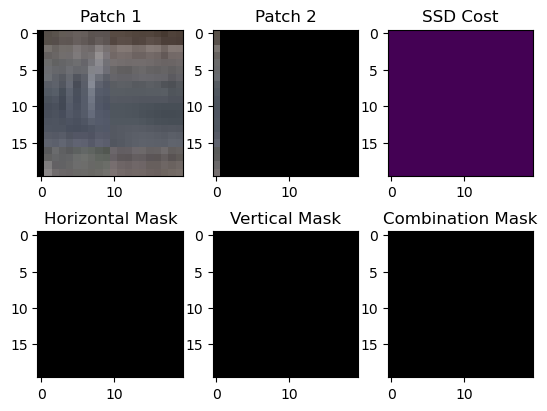

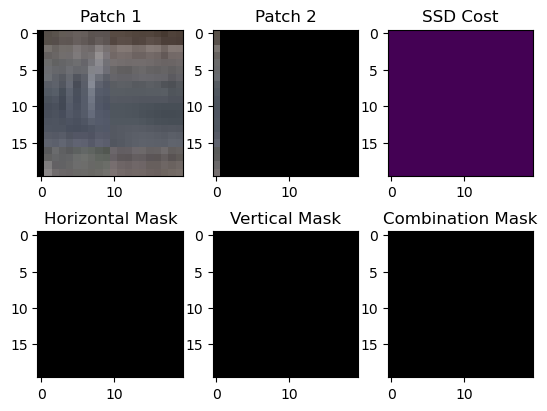

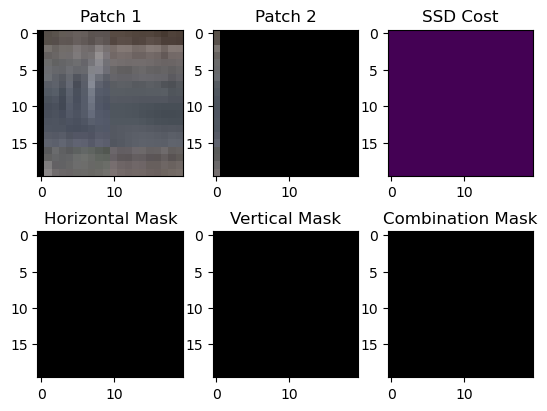

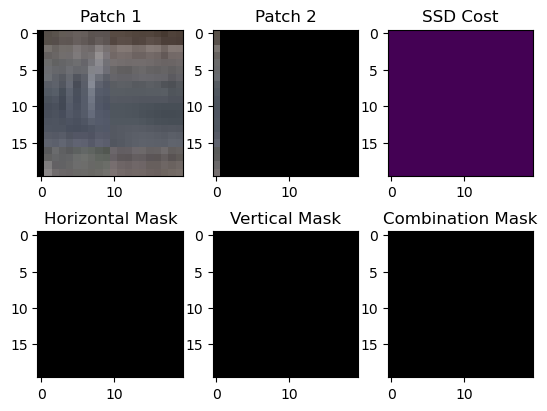

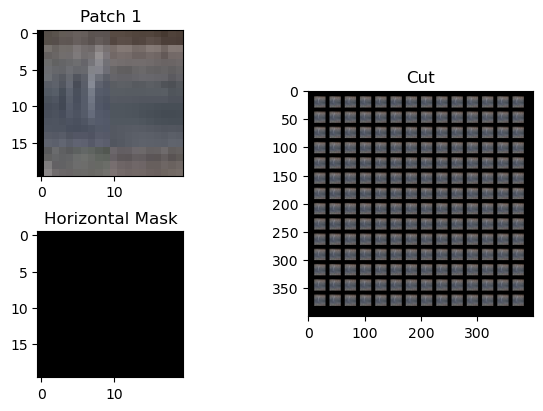

In [9]:
# Load the sample image and convert it to RGB
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)

# Display the original image with a label
plt.subplot(121)  # Create the first subplot
plt.imshow(sample_img)
plt.title("Original")  # Add a title

# Set the parameters for quilt_cut
out_size = 400
patch_size = 20
overlap = 11
tol = 5

# Generate and display the quilt_cut output image with a label
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.subplot(122)  # Create the second subplot
    plt.imshow(res)
    plt.title("Cut")  # Add a title

plt.show()  # Show both images with labels

### part IV: Texture Transfer (30 pts)

In [ ]:
def texture_transfer(sample, target, alpha):
    (r, c, _) = target.shape
    p_size = 15
    tol = 0.0001
    overlap = 3

    # Masks for different patch regions
    mask_left = np.zeros((p_size, p_size, 3))
    mask_left[:, :overlap, :] = 1

    mask_top = np.zeros((p_size, p_size, 3))
    mask_top[:overlap, :, :] = 1

    mask_other = np.zeros((p_size, p_size, 3))
    mask_other[:, :overlap, :] = 1
    mask_other[:overlap, :, :] = 1

    ones = np.ones((p_size, p_size, 3))

    result = np.zeros((r, c, 3))
    rows = (r - overlap) // (p_size - overlap)
    cols = (c - overlap) // (p_size - overlap)

    # Iterate over rows
    for i in range(0, rows):
        replace = result[i * (p_size - overlap):i * (p_size - overlap) + p_size, : p_size, :]
        target_patch = target[i * (p_size - overlap):i * (p_size - overlap) + p_size, : p_size, :]
        ssd_overlap = ssd_patch(replace, mask_top, sample)
        ssd_target = ssd_patch(target_patch, ones, sample)
        ssd_overlap = ssd_overlap[p_size // 2:-p_size // 2, p_size // 2:-p_size // 2]
        ssd_target = ssd_target[p_size // 2:-p_size // 2, p_size // 2:-p_size // 2]

        # Choose a sample and create a new patch
        (row, col) = choose_sample(ssd_overlap * alpha + ssd_target * (1 - alpha), tol)
        new_patch = sample[row:row + p_size, col:col + p_size, :].copy()

        # Calculate the difference and create a mask
        diff = replace[:overlap, :p_size, :] - new_patch[:overlap, :p_size, :]
        diff = diff[:, :, 0] + diff[:, :, 1] + diff[:, :, 2]
        mask = cut(diff)
        mask = mask.astype(np.uint8)

        # Apply the mask to the new patch and the replacement
        new_patch[:overlap, :p_size, 0] *= mask
        new_patch[:overlap, :p_size, 1] *= mask
        new_patch[:overlap, :p_size, 2] *= mask
        inv_mask = np.ones(mask.shape) - mask
        replace[:overlap, :p_size, 0] *= inv_mask
        replace[:overlap, :p_size, 1] *= inv_mask
        replace[:overlap, :p_size, 2] *= inv_mask
        replace += new_patch

    # Iterate over columns
    for i in range(1, cols):
        replace = result[:p_size, i * (p_size - overlap):i * (p_size - overlap) + p_size, :]
        target_patch = target[:p_size, i * (p_size - overlap):i * (p_size - overlap) + p_size, :]
        ssd_overlap = ssd_patch(replace, mask_left, sample)
        ssd_target = ssd_patch(target_patch, ones, sample)
        ssd_overlap = ssd_overlap[p_size // 2:-p_size // 2, p_size // 2:-p_size // 2]
        ssd_target = ssd_target[p_size // 2:-p_size // 2, p_size // 2:-p_size // 2]

        # Choose a sample and create a new patch
        (row, col) = choose_sample(ssd_overlap * alpha + ssd_target * (1 - alpha), tol)
        new_patch = sample[row:row + p_size, col:col + p_size, :].copy()

        # Calculate the difference and create a mask
        diff = replace[:p_size, :overlap, :] - new_patch[:p_size, :overlap, :]
        diff = diff[:, :, 0] + diff[:, :, 1] + diff[:, :, 2]
        mask = cut(diff)
        mask = mask.astype(np.uint8)

        # Apply the mask to the new patch and the replacement
        new_patch[:p_size, :overlap, 0] *= mask
        new_patch[:p_size, :overlap, 1] *= mask
        new_patch[:p_size, :overlap, 2] *= mask
        inv_mask = np.ones(mask.shape) - mask
        replace[:p_size, :overlap, 0] *= inv_mask
        replace[:p_size, :overlap, 1] *= inv_mask
        replace[:p_size, :overlap, 2] *= inv_mask
        replace += new_patch

    # Iterate over rows and columns for the remaining patches
    for i in range(1, rows):
        for j in range(1, cols):
            target_patch = target[i * (p_size - overlap):i * (p_size - overlap) + p_size,
                                   j * (p_size - overlap):j * (p_size - overlap) + p_size, :]
            replace = result[i * (p_size - overlap):i * (p_size - overlap) + p_size,
                                   j * (p_size - overlap):j * (p_size - overlap) + p_size, :]

            ssd_overlap = ssd_patch(replace, mask_other, sample)
            ssd_target = ssd_patch(target_patch, ones, sample)
            ssd_overlap = ssd_overlap[p_size // 2:-p_size // 2, p_size // 2:-p_size // 2]
            ssd_target = ssd_target[p_size // 2:-p_size // 2, p_size // 2:-p_size // 2]

            # Choose a sample and create a new patch
            (row, col) = choose_sample(ssd_overlap * alpha + ssd_target * (1 - alpha), tol)
            new_patch = sample[row:row + p_size, col:col + p_size, :].copy()

            # Calculate the difference and create masks
            diff = replace[:overlap, :p_size, :] - new_patch[:overlap, :p_size, :]
            diff = diff[:, :, 0] + diff[:, :, 1] + diff[:, :, 2]
            mask1 = cut(diff)

            diff = replace[:p_size, :overlap, :] - new_patch[:p_size, :overlap, :]
            diff = diff[:, :, 0] + diff[:, :, 1] + diff[:, :, 2]
            mask2 = cut(diff)

            mask_combined = np.ones((p_size, p_size))
            mask_combined[:overlap, :p_size] *= mask1
            mask_combined[:p_size, :overlap] *= mask2
            mask_combined = mask_combined.astype(np.uint8)

            # Apply the combined mask to the new patch and the replacement
            new_patch[:, :, 0] *= mask_combined
            new_patch[:, :, 1] *= mask_combined
            new_patch[:, :, 2] *= mask_combined
            inv_mask = np.ones(mask_combined.shape) - mask_combined
            replace[:, :, 0] *= inv_mask
            replace[:, :, 1] *= inv_mask
            replace[:, :, 2] *= inv_mask
            replace += new_patch

    return result

: 

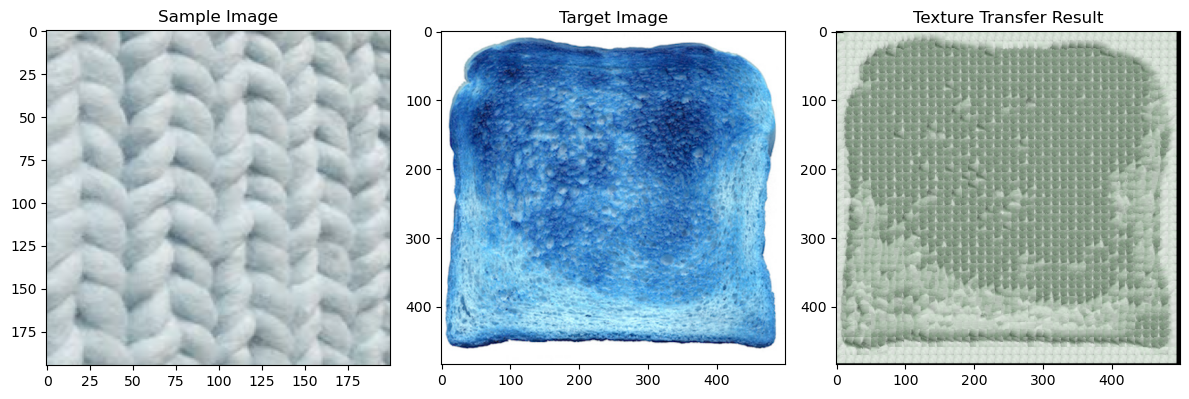

In [11]:
# Load the sample and target images
img = cv2.imread('samples/texture.png')
target = cv2.imread('samples/toast.jpg')

# Perform texture transfer
res = texture_transfer(img, target, 0.5)

# Convert the result to the appropriate format
res = res.astype(np.uint8)
res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)

# Manually swap the blue and red channels
res[:, :, 0], res[:, :, 2] = res[:, :, 2], res[:, :, 0]

# Create subplots for displaying the images
plt.figure(figsize=(12, 4))

# Sample Image
plt.subplot(131)
plt.imshow(img)
plt.title('Sample Image')

# Target Image
plt.subplot(132)
plt.imshow(target)
plt.title('Target Image')

# Resulting Image
plt.subplot(133)
plt.imshow(res)
plt.title('Texture Transfer Result')

# Adjust spacing for better visualization
plt.tight_layout()

# Show the subplots
plt.show()


### Bells & Whistles

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

In [62]:
# Load source and target images
source_image = cv2.imread('samples/toast.jpg')
target_image = cv2.imread('samples/bricks_small.jpg')

# Initialize output image as a copy of the target image
output_image = target_image.copy()

# Define the number of iterations
num_iterations = 100

for _ in range(num_iterations):
    # Calculate the difference between source and output images
    diff = source_image - output_image

    # Adjust the output image to reduce the difference
    output_image += diff * 0.1  # Adjust the factor for the rate of convergence

    # Clip pixel values to stay within [0, 255]
    output_image = np.clip(output_image, 0, 255)

# Convert the output image to a format that can be displayed in a notebook
output_image_bytes = cv2.imencode('.jpg', output_image)[1].tobytes()
output_image_display = Image(data=output_image_bytes)

# Display the image in the notebook
display(output_image_display)

ValueError: operands could not be broadcast together with shapes (484,500,3) (192,192,3) 

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

In [27]:
# face = cv2.imread('samples/linc.jpeg')
# toast = cv2.imread('samples/toast.jpg')

# # Resize the face to match the toast size
# face = cv2.resize(face, (toast.shape[1], toast.shape[0]))

# # Create the mask and apply Gaussian blur
# mask = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
# mask = cv2.GaussianBlur(mask, (0, 0), sigmaX=10)
# mask = mask / 255.0

# # Ensure the mask is in the correct range (0 to 1)
# mask = np.clip(mask, 0, 1)

# # Apply texture transfer and blending to the color images
# result = (face * mask[..., np.newaxis]) + (toast * (1 - mask[..., np.newaxis]))

# # Convert the result image to uint8 before displaying
# result = (result).astype(np.uint8)

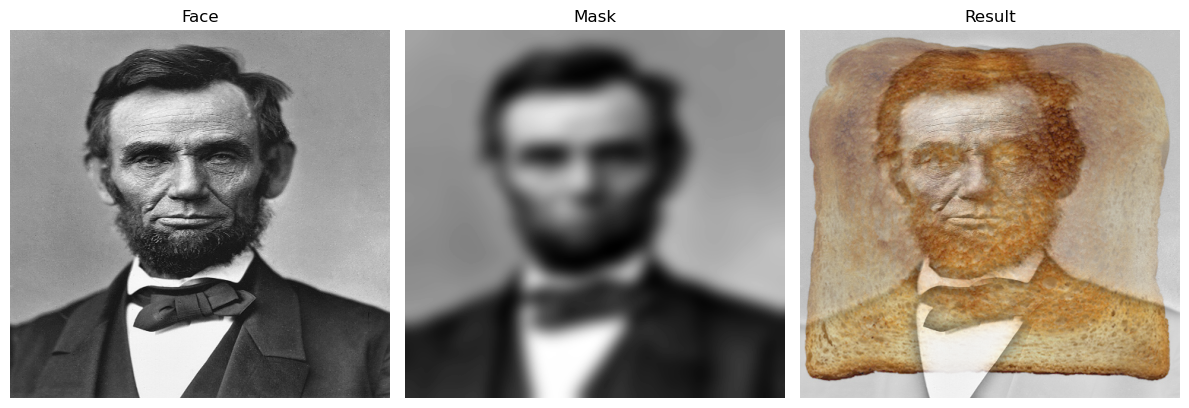

In [28]:
# # Display the face, mask, and result
# plt.figure(figsize=(12, 4))
# plt.subplot(131)
# plt.title('Face')
# plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
# plt.axis('off')

# plt.subplot(132)
# plt.title('Mask')
# plt.imshow(mask, cmap='gray')
# plt.axis('off')

# plt.subplot(133)
# plt.title('Result')
# plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
# plt.axis('off')

# plt.tight_layout()
# plt.show()

In [34]:
face = cv2.imread('samples/linc.jpeg')
toast = cv2.imread('samples/toast.jpg')

# Resize the face to match the toast size
face = cv2.resize(face, (toast.shape[1], toast.shape[0]))

# Create the mask and apply Gaussian blur
mask = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
mask = cv2.GaussianBlur(mask, (0, 0), sigmaX=10)
mask = mask / 255.0

# Ensure the mask is in the correct range (0 to 1)
mask = np.clip(mask, 0, 1)

# Laplacian pyramid blending
def pyramid_blending(A, B, mask, levels=6):
    # Generate Gaussian and Laplacian pyramids for A and B
    GA = A.copy()
    GB = B.copy()
    mask_pyr = mask.copy()
    pyramid = []
    for _ in range(levels):
        GA = cv2.pyrDown(GA)
        GB = cv2.pyrDown(GB)
        mask_pyr = cv2.pyrDown(mask_pyr)
        pyramid.append((GA, GB, mask_pyr))

    # Generate Laplacian pyramids for A and B
    LA = [A]
    LB = [B]
    for i in range(levels - 1, -1, -1):
        GA, GB, mask_pyr = pyramid[i]
        LA.append(LA[-1] - cv2.pyrUp(GA))
        LB.append(LB[-1] - cv2.pyrUp(GB))

    # Combine the Laplacian pyramids using the mask
    blended_pyramid = []
    for la, lb, mask_level in zip(LA, LB, [mask] + [p[2] for p in pyramid]):
        blended_pyramid.append(la * (1 - mask_level) + lb * mask_level)

    # Reconstruct the final image
    result = blended_pyramid[0]
    for i in range(1, levels + 1):
        result = cv2.pyrUp(result)
        result += blended_pyramid[i]

    return result

# Apply Laplacian pyramid blending to the color images
result = pyramid_blending(face, toast, mask)

# Convert the result image to uint8 before displaying
result = (result).astype(np.uint8)

ValueError: operands could not be broadcast together with shapes (484,500,3) (16,16,3) 

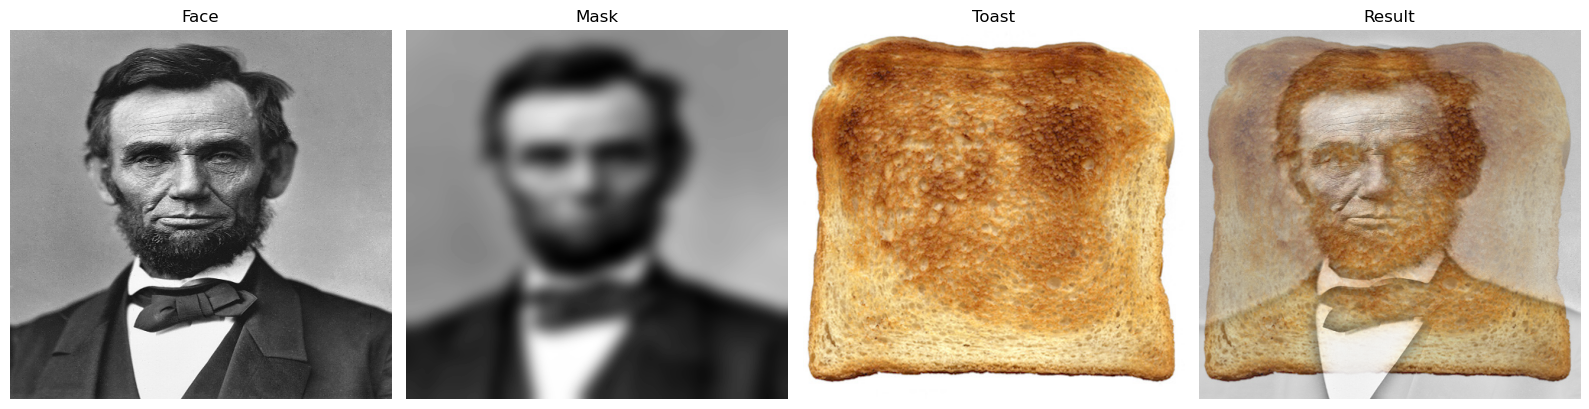

In [35]:
# Display the face, mask, toast, and result
plt.figure(figsize=(16, 4))

plt.subplot(141)
plt.title('Face')
plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(142)
plt.title('Mask')
plt.imshow(mask.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(143)
plt.title('Toast')
plt.imshow(cv2.cvtColor(toast, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(144)
plt.title('Result')
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).

In [12]:
def calculate_texture_similarity(patch1, patch2):
    # Calculate texture similarity between two image patches (e.g., using mean squared error)
    return np.mean((patch1 - patch2) ** 2)

def find_best_patch(target_image, hole_mask, patch_size):
    best_patch = None
    best_similarity = float('inf')

    for y in range(0, target_image.shape[0] - patch_size[0]):
        for x in range(0, target_image.shape[1] - patch_size[1]):
            # Extract a patch from the target image
            candidate_patch = target_image[y:y+patch_size[0], x:x+patch_size[1]]

            # Calculate the texture similarity with the hole region
            similarity = calculate_texture_similarity(candidate_patch, hole_mask)

            # Update the best patch if the current one is a better match
            if similarity < best_similarity:
                best_patch = candidate_patch
                best_similarity = similarity

    return best_patch

def complete_image(target_image, hole_mask, patch_size, num_iterations):
    completed_image = target_image.copy()

    for _ in range(num_iterations):
        # Find the location of the next hole to complete
        hole_coords = np.argwhere(hole_mask > 0)
        if len(hole_coords) == 0:
            break  # No more holes to fill

        y, x = hole_coords[np.random.randint(0, len(hole_coords))]  # Randomly select a hole
        patch = find_best_patch(completed_image, completed_image[y:y+patch_size[0], x:x+patch_size[1]], patch_size)

        # Replace the hole with the selected patch
        completed_image[y:y+patch_size[0], x:x+patch_size[1]] = patch

        # Update the hole mask
        hole_mask[y:y+patch_size[0], x:x+patch_size[1]] = 0

    return completed_image

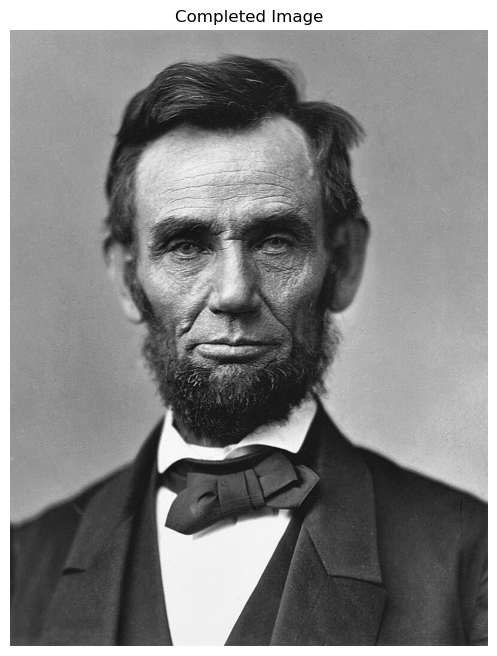

In [13]:
# Example usage:
target_image = cv2.imread('samples/linc.jpeg')
hole_mask = cv2.imread('samples/wallhole.jpg', cv2.IMREAD_GRAYSCALE)

patch_size = (50, 50)
num_iterations = 100
completed_image = complete_image(target_image, hole_mask, patch_size, num_iterations)

# Display the completed image using Matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(completed_image, cv2.COLOR_BGR2RGB))
plt.title('Completed Image')
plt.axis('off')  # Hide the axis
plt.show()